# 1st try AL with fastembed and Xgboost

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling
from modAL.density import information_density
from fastembed import TextEmbedding
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import joblib
import os

class EnhancedActiveLearningPipeline:
    def __init__(self, X_labeled, y_labeled, X_unlabeled, test_size=0.2, oracle_size=25000, random_state=42, batch_size=32):
        self.batch_size = batch_size
        self.embedder = TextEmbedding()
        self.random_state = random_state
        
        # Create embeddings for labeled data
        X_labeled_emb = self.create_embeddings(X_labeled)
        
        # Split labeled data
        X_train, X_temp, y_train, y_temp = train_test_split(X_labeled_emb, y_labeled, test_size=test_size*2, random_state=random_state, stratify=y_labeled)
        X_val, X_oracle, y_val, y_oracle = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=y_temp)

        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
        self.X_oracle, self.y_oracle = X_oracle, y_oracle
        
        # Create embeddings for unlabeled data in batches
        self.X_pool = self.create_embeddings(X_unlabeled)

        self.oracle_dict = dict(zip(map(tuple, X_oracle), y_oracle))

        self.scaler = StandardScaler()
        self.X_train_scaled = self.scaler.fit_transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_pool_scaled = self.scaler.transform(self.X_pool)

        # Initialize ensemble models
        self.models = [
            XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist', gpu_id=0),
            RandomForestClassifier(n_estimators=100, n_jobs=-1),
            LogisticRegression(max_iter=1000)
        ]
        
        self.learners = [
            ActiveLearner(estimator=model, X_training=self.X_train_scaled, y_training=self.y_train)
            for model in self.models
        ]
        
        self.committee = Committee(learner_list=self.learners, query_strategy=self.hybrid_sampling)

        self.performance_history = []
        self.cache_dir = "model_cache"
        os.makedirs(self.cache_dir, exist_ok=True)
        
        self.query_size = 10
        self.max_plateau_iterations = 5
        self.plateau_counter = 0
        self.best_performance = 0

    def create_embeddings(self, texts):
        embeddings = []
        for batch in DataLoader(texts, batch_size=self.batch_size):
            batch_embeddings = self.embedder.embed(batch)
            embeddings.extend(batch_embeddings)
        return np.array(embeddings)

    def hybrid_sampling(self, committee, X, n_instances=10):
        n_samples = len(X)
        
        # Uncertainty sampling using committee
        uncertainties = committee.vote_entropy(X)
        
        # Density-based sampling
        densities = information_density(X)
        
        # Combine uncertainty and density
        scores = uncertainties * densities
        
        # Add diversity component
        if len(self.performance_history) > 0:
            last_queried = self.X_train_scaled[-n_instances:]
            distances = np.min(np.linalg.norm(X[:, None, :] - last_queried[None, :, :], axis=-1), axis=-1)
            scores *= distances
        
        return np.argsort(scores)[-n_instances:]

    def query_oracle(self, X_query):
        y_query = []
        for x in X_query:
            if tuple(x) in self.oracle_dict:
                y_query.append(self.oracle_dict[tuple(x)])
            else:
                y_query.append(self.committee.predict(x.reshape(1, -1))[0])
        return np.array(y_query)

    def cache_models(self):
        for i, learner in enumerate(self.learners):
            joblib.dump(learner, os.path.join(self.cache_dir, f"model_{i}.joblib"))

    def load_cached_models(self):
        for i, learner in enumerate(self.learners):
            cached_model = joblib.load(os.path.join(self.cache_dir, f"model_{i}.joblib"))
            learner.estimator = cached_model.estimator
            learner.X_training = cached_model.X_training
            learner.y_training = cached_model.y_training

    def adaptive_query_size(self, current_performance):
        if len(self.performance_history) > 1:
            performance_change = current_performance - self.performance_history[-1][0]
            if performance_change > 0.01:
                self.query_size = min(self.query_size + 5, 50)
            elif performance_change < 0.001:
                self.query_size = max(self.query_size - 5, 5)
        return self.query_size

    def check_early_stopping(self, current_performance):
        if current_performance > self.best_performance:
            self.best_performance = current_performance
            self.plateau_counter = 0
        else:
            self.plateau_counter += 1
        
        if self.plateau_counter >= self.max_plateau_iterations:
            return True
        return False

    def active_learning_loop(self, n_queries=100):
        for _ in range(n_queries):
            query_idx, query_instance = self.committee.query(self.X_pool_scaled, n_instances=self.query_size)
            
            y_new = self.query_oracle(self.X_pool[query_idx])
            
            self.committee.teach(self.X_pool_scaled[query_idx], y_new)
            self.X_train = np.vstack((self.X_train, self.X_pool[query_idx]))
            self.y_train = np.concatenate((self.y_train, y_new))
            self.X_pool = np.delete(self.X_pool, query_idx, axis=0)
            self.X_pool_scaled = np.delete(self.X_pool_scaled, query_idx, axis=0)
            
            val_accuracy = self.committee.score(self.X_val_scaled, self.y_val)
            val_f1 = f1_score(self.y_val, self.committee.predict(self.X_val_scaled), average='weighted')
            self.performance_history.append((val_accuracy, val_f1))
            
            if len(self.performance_history) % 5 == 0:
                print(f"Iteration {len(self.performance_history)}, Validation Accuracy: {val_accuracy}, F1 Score: {val_f1}")
                self.cache_models()
            
            self.query_size = self.adaptive_query_size(val_accuracy)
            
            if self.check_early_stopping(val_accuracy):
                print("Early stopping triggered. Performance plateaued.")
                break

        return self.committee

    def run_pipeline(self, n_queries=100):
        self.active_learning_loop(n_queries)
        final_accuracy = self.committee.score(self.X_val_scaled, self.y_val)
        final_f1 = f1_score(self.y_val, self.committee.predict(self.X_val_scaled), average='weighted')
        print(f"Final Validation Accuracy: {final_accuracy}, F1 Score: {final_f1}")
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.performance_history)), [x[0] for x in self.performance_history], label='Accuracy')
        plt.plot(range(len(self.performance_history)), [x[1] for x in self.performance_history], label='F1 Score')
        plt.xlabel('Query Iteration')
        plt.ylabel('Score')
        plt.title('Active Learning Performance')
        plt.legend()
        plt.show()

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling
from fastembed import TextEmbedding
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import pairwise_distances_chunked
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics.pairwise import pairwise_distances
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging
from tqdm import tqdm
import hashlib

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class EnhancedActiveLearningPipeline:
    def __init__(self, data, text_column, label_column, test_size=0.2, initial_labeled_ratio=0.05, n_splits=5, random_state=42, batch_size=64):
        self.random_state = random_state
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio

        logger.info("Initializing EnhancedActiveLearningPipeline")
        
        # Check if required columns exist
        required_columns = [text_column, label_column]
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"DataFrame is missing one or more required columns: {required_columns}")
        
        self.data = data
        self.text_column = text_column
        self.label_column = label_column
        
        # Initialize embedder
        self.embedder = TextEmbedding(model_name="BAAI/bge-small-en-v1.5", max_length=512)
        
        # Set up embedding cache
        self.cache_dir = "embedding_cache"
        os.makedirs(self.cache_dir, exist_ok=True)
        
        # Label encoding
        self.le = LabelEncoder()
        self.data['encoded_label'] = self.le.fit_transform(self.data[label_column])
        logger.info(f"Encoded labels: {self.le.classes_}")
        
        # Create embeddings
        logger.info("Creating embeddings for all data")
        self.embeddings = self.create_embeddings(self.data[text_column])
        
        # Prepare for cross-validation
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        self.folds = list(self.skf.split(self.data, self.data['encoded_label']))
        
        # Initialize models (will be properly initialized in prepare_fold)
        self.models = {}
        
        self.cv_results = {}
        
    def create_embeddings(self, texts):
        logger.info(f"Starting embedding creation for {len(texts)} texts")

        dataset = TensorDataset(torch.arange(len(texts)))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_embeddings = []
        cache_hits = 0
        for batch in tqdm(dataloader, desc="Creating embeddings", unit="batch"):
            batch_texts = [texts.iloc[i.item()] for i in batch[0]]

            batch_embeddings = []
            for text in batch_texts:
                text_hash = hashlib.md5(str(text).encode()).hexdigest()
                cache_file = os.path.join(self.cache_dir, f"{text_hash}.npy")
                
                if os.path.exists(cache_file):
                    embedding = np.load(cache_file)
                    cache_hits += 1
                else:
                    embedding = list(self.embedder.embed([str(text)]))[0]
                    np.save(cache_file, embedding)
                
                batch_embeddings.append(embedding)
            
            all_embeddings.extend(batch_embeddings)

        logger.info(f"Embedding cache hits: {cache_hits}/{len(texts)}")
        return np.array(all_embeddings)


    def hybrid_sampling(self, committee, X, n_instances=10, batch_size=1000):
        logger.info(f"Performing hybrid sampling for {n_instances} instances")
        uncertainties = entropy_sampling(committee, X)
        
        # Function to process distance matrix chunks
        def min_distances(D_chunk, start):
            min_vals = np.min(D_chunk, axis=1)
            return min_vals

        # Calculate diversity scores in batches
        diversity_scores = np.zeros(X.shape[0])
        for chunk in pairwise_distances_chunked(X, metric='cosine', working_memory=100, reduce_func=min_distances):
            diversity_scores += chunk

        # Normalize scores
        uncertainties = (uncertainties - uncertainties.min()) / (uncertainties.max() - uncertainties.min())
        diversity_scores = (diversity_scores - diversity_scores.min()) / (diversity_scores.max() - diversity_scores.min())

        # Combine scores
        combined_scores = uncertainties * diversity_scores
        
        query_indices = np.argsort(combined_scores)[-n_instances:]
        return query_indices

    def prepare_fold(self, fold_idx):
        train_idx, test_idx = self.folds[fold_idx]
        train_data = self.data.iloc[train_idx]
        test_data = self.data.iloc[test_idx]
        
        # Ensure balanced initial labeled set
        labeled_size = int(len(train_data) * self.initial_labeled_ratio)
        labeled_data = train_data.groupby('encoded_label').apply(
            lambda x: x.sample(min(len(x), labeled_size // len(self.le.classes_)), random_state=self.random_state)
        ).droplevel(0)  # Remove the 'encoded_label' level from the index
        
        unlabeled_pool = train_data.drop(labeled_data.index)
        
        X_train = self.embeddings[train_idx]
        X_test = self.embeddings[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        labeled_indices = np.where(train_data.index.isin(labeled_data.index))[0]
        X_labeled = X_train_scaled[labeled_indices]
        y_labeled = labeled_data['encoded_label'].values
        
        X_pool = np.delete(X_train_scaled, labeled_indices, axis=0)
        
        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_labeled), y=y_labeled)
        class_weight_dict = dict(zip(np.unique(y_labeled), class_weights))
        
        # Initialize models with class weights
        self.models = {
            'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', tree_method='hist', random_state=self.random_state, scale_pos_weight=class_weights[1] / class_weights[0]),
            'RandomForest': RandomForestClassifier(n_estimators=200, class_weight=class_weight_dict, n_jobs=-1, random_state=self.random_state),
            'LogisticRegression': LogisticRegression(max_iter=2000, class_weight=class_weight_dict, random_state=self.random_state)
        }
        
        learners = [
            ActiveLearner(
                estimator=model,
                X_training=X_labeled,
                y_training=y_labeled
            ) for name, model in self.models.items()
        ]
        committee = Committee(learner_list=learners, query_strategy=self.hybrid_sampling)
        
        return labeled_data, unlabeled_pool, test_data, committee, scaler, X_labeled, X_pool, X_test_scaled

    def run_pipeline(self, n_queries=100, instances_per_query=10):
        for fold_idx in range(self.n_splits):
            logger.info(f"Starting fold {fold_idx + 1}/{self.n_splits}")
            labeled_data, unlabeled_pool, test_data, committee, scaler, X_labeled, X_pool, X_test_scaled = self.prepare_fold(fold_idx)
            
            performance_history = []
            for iteration in tqdm(range(n_queries), desc=f"Active Learning Progress (Fold {fold_idx + 1})"):
                # Query instances
                query_idx, _ = committee.query(X_pool, n_instances=instances_per_query)
                
                # Update model
                committee.teach(
                    X=X_pool[query_idx],
                    y=unlabeled_pool.iloc[query_idx]['encoded_label'].values
                )
                
                # Move queried instances from unlabeled pool to labeled data
                queried_data = unlabeled_pool.iloc[query_idx]
                labeled_data = pd.concat([labeled_data, queried_data])
                unlabeled_pool = unlabeled_pool.drop(queried_data.index)
                
                # Update X_labeled and X_pool
                X_labeled = np.vstack((X_labeled, X_pool[query_idx]))
                X_pool = np.delete(X_pool, query_idx, axis=0)
                
                # Evaluate
                predictions = committee.predict(X_test_scaled)
                accuracy = accuracy_score(test_data['encoded_label'], predictions)
                f1 = f1_score(test_data['encoded_label'], predictions, average='weighted')
                
                performance_history.append((accuracy, f1))
                
                if iteration % 5 == 0:
                    logger.info(f"Iteration {iteration}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
            
            # Store results for this fold
            self.cv_results[f'Fold_{fold_idx + 1}'] = performance_history
            
            # Final evaluation for this fold
            final_predictions = committee.predict(X_test_scaled)
            logger.info(f"Fold {fold_idx + 1} Final Results:")
            logger.info(f"Accuracy: {accuracy_score(test_data['encoded_label'], final_predictions):.4f}")
            logger.info(f"F1 Score: {f1_score(test_data['encoded_label'], final_predictions, average='weighted'):.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(test_data['encoded_label'], final_predictions, target_names=self.le.classes_))
            
            self.plot_confusion_matrix(test_data['encoded_label'], final_predictions, self.le.classes_, fold_idx)
        
        self.plot_learning_curves()

    def plot_confusion_matrix(self, y_true, y_pred, labels, fold_idx):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title(f'Confusion Matrix (Fold {fold_idx + 1})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        #plt.savefig(f'confusion_matrix_fold_{fold_idx + 1}.png')
        plt.close()

    def plot_learning_curves(self):
        plt.figure(figsize=(12, 6))
        for fold, results in self.cv_results.items():
            accuracies, f1_scores = zip(*results)
            plt.plot(range(len(accuracies)), accuracies, label=f'{fold} Accuracy')
            plt.plot(range(len(f1_scores)), f1_scores, label=f'{fold} F1 Score')
        
        plt.xlabel('Query Iteration')
        plt.ylabel('Score')
        plt.title('Active Learning Performance Across Folds')
        plt.legend()
        #plt.savefig('active_learning_performance.png')
        plt.close()

In [5]:
logger.info("Starting the Active Learning Pipeline")

# Load your dataset
logger.info("Loading dataset")
logger.info(f"Dataset loaded. Shape: {df.shape}")
logger.info(f"Columns: {df.columns.tolist()}")

# Check for required columns
required_columns = ['preprocessed', 'final_classification']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    logger.error(f"Dataset is missing columns: {missing_columns}")
    raise ValueError(f"Dataset is missing required columns")

logger.info(f"'final_classification' unique values: {df['final_classification'].unique()}")

# Initialize and run the pipeline
try:
    pipeline = EnhancedActiveLearningPipeline(
        data=df,
        text_column='preprocessed',
        label_column='final_classification',
        test_size=0.2,
        initial_labeled_ratio=0.05,
        n_splits=5,
        random_state=42,
        batch_size=64
    )
    
    logger.info("Starting pipeline execution")
    pipeline.run_pipeline(n_queries=50, instances_per_query=10)
    logger.info("Active Learning Pipeline completed successfully")

except Exception as e:
    logger.error(f"An error occurred during pipeline execution: {str(e)}")
    logger.exception("Exception details:")
    raise

# After pipeline execution, you can access results
for fold, results in pipeline.cv_results.items():
    logger.info(f"Results for {fold}:")
    final_accuracy, final_f1 = results[-1]
    logger.info(f"Final Accuracy: {final_accuracy:.4f}, Final F1 Score: {final_f1:.4f}")

logger.info("Pipeline execution and result logging completed")

2024-09-21 15:38:47,409 - INFO - Starting the Active Learning Pipeline
2024-09-21 15:38:47,410 - INFO - Loading dataset


NameError: name 'df' is not defined

# AL 2: 
- Hybrid search with entrompy + other
- FAISS for calculating distance
- New Models 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
from modAL.models import ActiveLearner, Committee
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import time
from scipy.stats import entropy
from fastembed import TextEmbedding
import os
import hashlib
from torch.utils.data import DataLoader, TensorDataset
import torch
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class EmbeddingEnabledActiveLearningPipeline:
    def __init__(self, data, text_column, label_column, test_size=0.2, initial_labeled_ratio=0.05, n_splits=5, random_state=42, batch_size=64):
        self.data = data
        self.text_column = text_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.n_splits = n_splits
        self.random_state = random_state
        self.batch_size = batch_size
        self.scaler = StandardScaler()
        self.le = LabelEncoder()
        
        logger.info("Initializing EmbeddingEnabledActiveLearningPipeline")
        
        # Check for required columns
        required_columns = [text_column, label_column]
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            logger.error(f"Dataset is missing columns: {missing_columns}")
            raise ValueError(f"Dataset is missing required columns: {missing_columns}")
        
        # Initialize embedder
        self.embedder = TextEmbedding(model_name="BAAI/bge-small-en-v1.5", max_length=512)
        
        # Set up embedding cache
        self.cache_dir = "embedding_cache"
        os.makedirs(self.cache_dir, exist_ok=True)
        
        # Label encoding
        self.data['encoded_label'] = self.le.fit_transform(self.data[label_column])
        logger.info(f"Encoded labels: {self.le.classes_}")
        
    def create_embeddings(self, texts):
        logger.info(f"Starting embedding creation for {len(texts)} texts")

        dataset = TensorDataset(torch.arange(len(texts)))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_embeddings = []
        cache_hits = 0
        for batch in tqdm(dataloader, desc="Creating embeddings", unit="batch"):
            batch_texts = [texts.iloc[i.item()] for i in batch[0]]

            batch_embeddings = []
            for text in batch_texts:
                text_hash = hashlib.md5(str(text).encode()).hexdigest()
                cache_file = os.path.join(self.cache_dir, f"{text_hash}.npy")
                
                if os.path.exists(cache_file):
                    embedding = np.load(cache_file)
                    cache_hits += 1
                else:
                    embedding = list(self.embedder.embed([str(text)]))[0]
                    np.save(cache_file, embedding)
                
                batch_embeddings.append(embedding)
            
            all_embeddings.extend(batch_embeddings)

        logger.info(f"Embedding cache hits: {cache_hits}/{len(texts)}")
        return np.array(all_embeddings)
    
    def create_optimal_text_ensemble(self):
        models = {
            'LogisticRegression': LogisticRegression(C=1.0, penalty='l1', solver='saga', random_state=self.random_state),
            'SGD': SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=self.random_state),
            'LinearSVM': LinearSVC(C=1.0, random_state=self.random_state),
            'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, tree_method='hist', random_state=self.random_state)
        }
        
        learners = [
            ActiveLearner(estimator=model, query_strategy=self.uncertainty_sampling)
            for name, model in models.items()
        ]
        
        return Committee(learner_list=learners, query_strategy=self.batch_sampling)
    
    def prepare_data(self):
        logger.info("Creating embeddings for all data")
        embeddings = self.create_embeddings(self.data[self.text_column])
        
        # Scale features
        X = self.scaler.fit_transform(embeddings)
        y = self.data['encoded_label'].values
        
        return X, y
    
    def uncertainty_sampling(self, classifier, X, n_instances=1):
        probas = classifier.predict_proba(X)
        uncertainties = entropy(probas, axis=1)
        return np.argsort(uncertainties)[-n_instances:]
    
    def batch_sampling(self, committee, X, n_instances=10, epsilon=0.1):
        # Get disagreement scores
        votes = np.array([member.predict(X) for member in committee])
        vote_entropy = entropy(np.apply_along_axis(lambda x: np.bincount(x, minlength=len(np.unique(votes))), axis=0, arr=votes), axis=1)
        
        # Exploration-Exploitation trade-off
        if np.random.random() < epsilon:
            return np.random.choice(range(len(X)), size=n_instances, replace=False)
        
        selected_indices = []
        
        while len(selected_indices) < n_instances:
            if not selected_indices:
                idx = np.argmax(vote_entropy)
            else:
                # Compute distances to already selected points
                distances = np.min([np.sum((X - X[i])**2, axis=1) for i in selected_indices], axis=0)
                
                # Combine distance and entropy
                scores = distances * vote_entropy
                idx = np.argmax(scores)
            
            selected_indices.append(idx)
            vote_entropy[idx] = -np.inf  # Ensure we don't select the same point again
        
        return selected_indices
    
    def run_pipeline(self, n_queries=100, instances_per_query=10):
        logger.info("Starting pipeline execution")
        X, y = self.prepare_data()
        
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        self.cv_results = {}
        
        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            logger.info(f"Starting fold {fold}/{self.n_splits}")
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Create initial labeled pool
            n_initial = int(len(X_train) * self.initial_labeled_ratio)
            initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
            X_initial = X_train[initial_idx]
            y_initial = y_train[initial_idx]
            
            # Create unlabeled pool
            X_pool = np.delete(X_train, initial_idx, axis=0)
            y_pool = np.delete(y_train, initial_idx)
            
            committee = self.create_optimal_text_ensemble()
            committee.teach(X_initial, y_initial)
            
            performance_history = []
            
            for iteration in tqdm(range(n_queries), desc=f"Active Learning Progress (Fold {fold})"):
                # Query instances
                query_idx, _ = committee.query(X_pool, n_instances=instances_per_query)
                
                # Teach committee
                committee.teach(
                    X=X_pool[query_idx],
                    y=y_pool[query_idx]
                )
                
                # Remove queried instances from pool
                X_pool = np.delete(X_pool, query_idx, axis=0)
                y_pool = np.delete(y_pool, query_idx)
                
                # Evaluate
                y_pred = committee.predict(X_test)
                accuracy = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                performance_history.append((accuracy, f1))
                
                if iteration % 5 == 0:
                    logger.info(f"Iteration {iteration}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
            
            self.cv_results[f'Fold_{fold}'] = performance_history
            
            # Final evaluation for this fold
            y_pred = committee.predict(X_test)
            logger.info(f"Fold {fold} Final Results:")
            logger.info(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
            logger.info(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
            logger.info("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        logger.info("Active Learning Pipeline completed successfully")
        return self.cv_results

In [ ]:
# Usage
logger.info("Starting the Active Learning Pipeline")

# Load your dataset
logger.info("Loading dataset")
#df = pd.read_csv('your_data.csv')  # Replace with your data loading method
logger.info(f"Dataset loaded. Shape: {df.shape}")
logger.info(f"Columns: {df.columns.tolist()}")

logger.info(f"'final_classification' unique values: {df['final_classification'].unique()}")

# Initialize and run the pipeline
try:
    pipeline = EmbeddingEnabledActiveLearningPipeline(
        data=df,
        text_column='preprocessed',
        label_column='final_classification',
        test_size=0.2,
        initial_labeled_ratio=0.05,
        n_splits=5,
        random_state=42,
        batch_size=64
    )
    
    results = pipeline.run_pipeline(n_queries=50, instances_per_query=10)
    
    # After pipeline execution, access and log results
    for fold, fold_results in results.items():
        logger.info(f"Results for {fold}:")
        final_accuracy, final_f1 = fold_results[-1]
        logger.info(f"Final Accuracy: {final_accuracy:.4f}, Final F1 Score: {final_f1:.4f}")

    logger.info("Pipeline execution and result logging completed")

except Exception as e:
    logger.error(f"An error occurred during pipeline execution: {str(e)}")
    logger.exception("Exception details:")
    raise

# Plot learning curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for fold, history in results.items():
    accuracies, f1_scores = zip(*history)
    plt.plot(f1_scores, label=f'{fold} F1 Score')

plt.xlabel('Query Iteration')
plt.ylabel('F1 Score')
plt.title('Active Learning Performance Across Folds')
plt.legend()
plt.show()

# AL with normal batching  (on BAAI embed, acc: 0.74, with smote)
- here need to try same but with weights + smote. 
- here need to try same but with weights + smote + distance from the center. 

2024-09-21 17:30:03,355 - INFO - Initializing OptimizedActiveLearningPipeline
2024-09-21 17:30:03,356 - INFO - Data file: llama_cleaned_final_classification.parquet
2024-09-21 17:30:03,356 - INFO - Embedding column: dense_embedding
2024-09-21 17:30:03,357 - INFO - Label column: cleaned_classification
2024-09-21 17:30:03,357 - INFO - Test size: 0.2
2024-09-21 17:30:03,358 - INFO - Initial labeled ratio: 0.3
2024-09-21 17:30:03,358 - INFO - Random state: 42
2024-09-21 17:30:03,359 - INFO - Starting optimized active learning pipeline with QBC
2024-09-21 17:30:03,362 - INFO - Loading and preprocessing data
2024-09-21 17:30:15,011 - INFO - Data loaded and preprocessed in 11.65 seconds
2024-09-21 17:30:15,012 - INFO - Data shape: (79763, 384)
2024-09-21 17:30:15,013 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-21 17:30:15,014 - INFO - Class distribution: [26685 47700  5378]
2024-09-21 17:30:15,271 - INFO - Starting active learning with Query by Committee
2024-09-21

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-21 17:32:44,455 - INFO - QBC - Iteration 5/50: Accuracy = 0.7491
2024-09-21 17:35:07,473 - INFO - QBC - Iteration 10/50: Accuracy = 0.7479
2024-09-21 17:37:08,800 - INFO - QBC - Early stopping at iteration 14 due to no improvement
2024-09-21 17:37:08,801 - INFO - QBC - Active learning completed in 413.53 seconds
2024-09-21 17:37:08,802 - INFO - QBC - Final accuracy: 0.7493
2024-09-21 17:37:09,135 - INFO - Optimized Active Learning Pipeline with QBC completed in 425.78 seconds
2024-09-21 17:37:09,135 - INFO - Query by Committee - Initial accuracy: 0.7497, Final accuracy: 0.7493
2024-09-21 17:37:09,449 - INFO - Classification Report:
              precision    recall  f1-score   support

 antiscience       0.71      0.68      0.70      5337
     neutral       0.89      0.82      0.85      9540
  proscience       0.23      0.44      0.31      1076

    accuracy                           0.75     15953
   macro avg       0.61      0.65      0.62     15953
weighted avg       0.78   

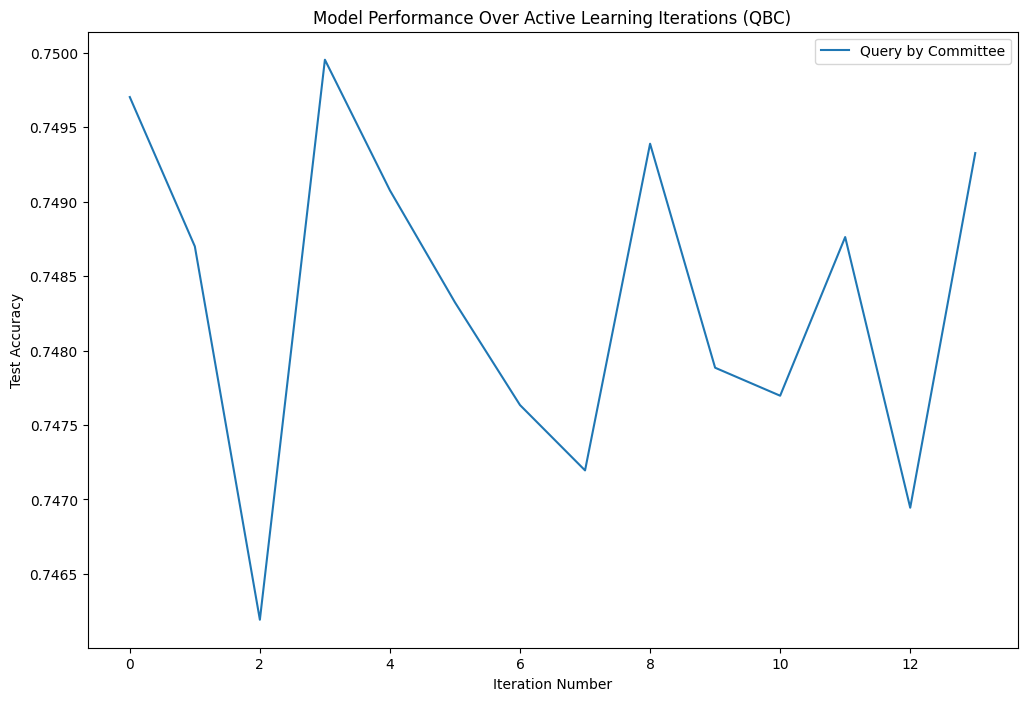

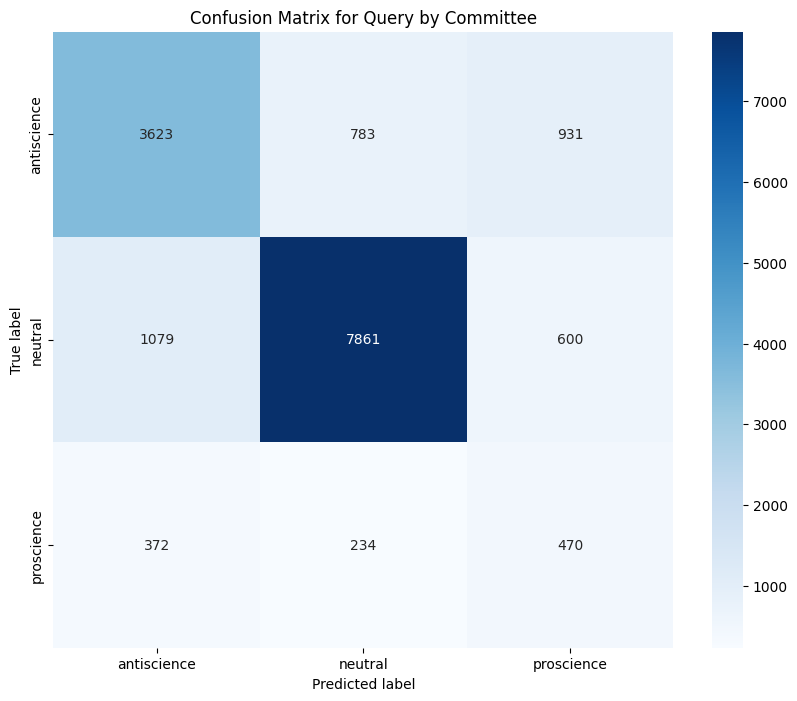

              precision    recall  f1-score   support

 antiscience       0.71      0.68      0.70      5337
     neutral       0.89      0.82      0.85      9540
  proscience       0.23      0.44      0.31      1076

    accuracy                           0.75     15953
   macro avg       0.61      0.65      0.62     15953
weighted avg       0.78      0.75      0.76     15953



In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from modAL.models import ActiveLearner, Committee
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from joblib import Memory

# Set up caching
cachedir = './cachedir'
memory = Memory(cachedir, verbose=0)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class OptimizedActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing OptimizedActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    @staticmethod
    def parse_embedding(embedding_string):
        return np.fromstring(embedding_string.strip('[]'), sep=',')

    @staticmethod
    @memory.cache
    def load_and_preprocess_data(data_file, embedding_column, label_column, test_size, random_state):
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data efficiently
        data = pd.read_parquet(data_file)
        
        # Convert embedding column
        data[embedding_column] = data[embedding_column].apply(OptimizedActiveLearningPipeline.parse_embedding)
        
        le = LabelEncoder()
        le.fit(data[label_column])
        data['encoded_label'] = le.transform(data[label_column])
        
        X = np.stack(data[embedding_column].values)
        y = data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {X.shape}")
        logger.info(f"Encoded labels: {le.classes_}")
        logger.info(f"Class distribution: {np.bincount(y)}")
        
        return X_train, y_train, X_test, y_test, le
    
    def train_with_qbc(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                       n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], np.ndarray]:
        logger.info("Starting active learning with Query by Committee")
        start_time = time.time()

        # Split the training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )

        # Apply SMOTE only to the initial labeled set
        smote = SMOTE(random_state=self.random_state)
        X_initial_resampled, y_initial_resampled = smote.fit_resample(X_initial, y_initial)

        logger.info(f"Class distribution after SMOTE (initial set): {np.bincount(y_initial_resampled)}")

        # Compute class weights based on the resampled initial set
        class_weights = compute_class_weight('balanced', classes=np.unique(y_initial_resampled), y=y_initial_resampled)
        class_weight_dict = dict(zip(np.unique(y_initial_resampled), class_weights))

        # Initialize models with optimized parameters
        models = [
            XGBClassifier(
                objective='multi:softprob', 
                num_class=len(self.le.classes_), 
                random_state=self.random_state,
                max_delta_step=1,
                min_child_weight=5,
                n_jobs=-1,  # Use all available cores
                tree_method='hist'  # Faster tree method
            ),
            LogisticRegression(random_state=self.random_state, max_iter=1000, class_weight=class_weight_dict, n_jobs=-1),
            GaussianNB()
        ]

        # Create committee
        learners = [ActiveLearner(estimator=model, X_training=X_initial_resampled, y_training=y_initial_resampled) for model in models]
        committee = Committee(learner_list=learners, query_strategy=self.optimized_query_strategy)

        performance_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_committee = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"QBC - Final accuracy: {performance_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "Query by Committee", performance_history, cm

    @staticmethod
    def optimized_query_strategy(committee, X, n_instances=1):
        # Get probabilities from each learner
        votes = committee.vote(X)
        
        # Calculate entropy
        entropy_scores = -np.sum(votes * np.log(votes + 1e-10), axis=1)
        
        # Calculate margin (difference between top two probabilities)
        sorted_votes = np.sort(votes, axis=1)
        margin_scores = sorted_votes[:, -1] - sorted_votes[:, -2]
        
        # Combine scores
        combined_scores = entropy_scores * 0.7 + (1 - margin_scores) * 0.3  # Note: we use (1 - margin_scores) so that higher is more uncertain
        
        # Return the indices of the instances with the highest combined scores
        return np.argsort(combined_scores)[-n_instances:]

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting optimized active learning pipeline with QBC")
        start_time = time.time()

        X_train, y_train, X_test, y_test, self.le = self.load_and_preprocess_data(
            self.data_file, self.embedding_column, self.label_column, self.test_size, self.random_state
        )

        model_name, performance_history, cm = self.train_with_qbc(X_train, y_train, X_test, y_test)

        self.model_performance = {model_name: performance_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"Optimized Active Learning Pipeline with QBC completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_committee.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=model_name)
        plt.title('Model Performance Over Active Learning Iterations (QBC)')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.show()

    def plot_confusion_matrices(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Usage
pipeline = OptimizedActiveLearningPipeline("llama_cleaned_final_classification.parquet", "dense_embedding", "cleaned_classification")
results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrices()
print(class_report)

# AL with normal batching  (on SBERT embed, acc: 0.79, lower than xgb alone.)
- here i do not have weights, nor smote -> try to add both.
- here performances where good, but need to add auc-roc and logloss on xgb.
- also try to add the distance from centroids for adding features

In [4]:
import pandas as pd
import pickle

def pickle_to_csv(pickle_file_path, csv_file_path):
    # Load the pickle file
    with open(pickle_file_path, 'rb') as pickle_file:
        data = pickle.load(pickle_file)
    
    # Check if the loaded data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("The pickle file does not contain a pandas DataFrame")
    
    # Save the DataFrame as a CSV file
    data.to_csv(csv_file_path, index=False)
    print(f"CSV file saved successfully at: {csv_file_path}")

# Example usage
pickle_file_path = 'final_embedded_df.pkl'
csv_file_path = 'sbert_llama_classifications.csv'

pickle_to_csv(pickle_file_path, csv_file_path)

CSV file saved successfully at: sbert_llama_classifications.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
from typing import List, Tuple, Dict
import argparse
import time
import matplotlib.pyplot as plt
import seaborn as sns
import sys

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ActiveLearningPipelineQBC:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data = pd.read_csv(data_file)
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        self._preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing ActiveLearningPipelineQBC")
        logger.info(f"Data shape: {self.data.shape}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def _preprocess_data(self) -> None:
        # Optimize: Use a more efficient method to convert string to numpy array
        self.data[self.embedding_column] = self.data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
        
        self.le.fit(self.data[self.label_column])
        self.data['encoded_label'] = self.le.transform(self.data[self.label_column])
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Preparing data")
        X = np.stack(self.data[self.embedding_column].values)
        y = self.data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )
        
        self._log_data_info(X_initial, y_initial, X_pool, y_pool, X_test, y_test)
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def _log_data_info(self, X_initial, y_initial, X_pool, y_pool, X_test, y_test) -> None:
        logger.info(f"Initial labeled set shape: {X_initial.shape}")
        logger.info(f"Pool shape: {X_pool.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        logger.info(f"Unique labels in initial labeled set: {np.unique(y_initial)}")
        logger.info(f"Unique labels in pool: {np.unique(y_pool)}")
        logger.info(f"Unique labels in test: {np.unique(y_test)}")

    def train_with_qbc(self, X_initial: np.ndarray, Y_initial: np.ndarray, 
                       X_pool: np.ndarray, Y_pool: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, 
                       n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], np.ndarray]:
        logger.info("Starting active learning with Query by Committee")
        start_time = time.time()

        # Initialize the committee with ActiveLearners
        learners = [
            ActiveLearner(estimator=RandomForestClassifier(n_estimators=100, random_state=self.random_state)),
            ActiveLearner(estimator=ExtraTreesClassifier(n_estimators=100, random_state=self.random_state)),
            ActiveLearner(estimator=XGBClassifier(objective='multi:softprob', num_class=len(self.le.classes_), random_state=self.random_state)) #missing logloss
        ]

        committee = Committee(learner_list=learners, query_strategy=entropy_sampling)
        committee.fit(X_initial, Y_initial)

        performance_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            committee.teach(X_pool[query_idx], Y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            Y_pool = np.delete(Y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(Y_test, y_pred)
            performance_history.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"QBC - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"QBC - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"QBC - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"QBC - Final accuracy: {performance_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(Y_test, y_pred_final)
        cr = classification_report(Y_test, y_pred_final, target_names=self.le.classes_)
        logger.info("Classification Report:")
        logger.info(f"\n{cr}")
        
        return "Query by Committee", performance_history, cm
    
    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], Dict[str, str]]:
        logger.info("Starting active learning pipeline with QBC")
        start_time = time.time()

        X_initial, Y_initial, X_pool, Y_pool, X_test, Y_test = self.prepare_data()

        self._log_data_split_info(X_initial, X_pool, X_test, Y_initial, Y_pool, Y_test)

        model_name, performance_history, cm, cr = self.train_with_qbc(
            X_initial, Y_initial, X_pool, Y_pool, X_test, Y_test
        )

        self.model_performance = {model_name: performance_history}
        self.confusion_matrices = {model_name: cm}
        self.classification_reports = {model_name: cr}
        
        end_time = time.time()
        logger.info(f"Active Learning Pipeline with QBC completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")

        return self.model_performance, self.confusion_matrices, self.classification_reports


    def _log_data_split_info(self, X_initial, X_pool, X_test, Y_initial, Y_pool, Y_test):
        logger.info(f"Initial training set size: {len(X_initial)}")
        logger.info(f"Pool size: {len(X_pool)}")
        logger.info(f"Test set size: {len(X_test)}")
        logger.info(f"Label distribution in initial training set: {np.bincount(Y_initial)}")
        logger.info(f"Label distribution in pool: {np.bincount(Y_pool)}")
        logger.info(f"Label distribution in test set: {np.bincount(Y_test)}")

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=model_name)
        plt.title('Model Performance Over Active Learning Iterations (QBC)')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.show()
        logger.info("Results plot displayed")

    def plot_confusion_matrices(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
            logger.info(f"Confusion matrix for {model_name} displayed")
            
def parse_arguments():
    parser = argparse.ArgumentParser(description="Run Active Learning Pipeline with Query by Committee")
    parser.add_argument("--data_file", type=str, help="Path to the data CSV file")
    parser.add_argument("--embedding_column", type=str, default="dense_embedding", help="Name of the embedding column")
    parser.add_argument("--label_column", type=str, default="cleaned_classification", help="Name of the label column")
    
    if len(sys.argv) > 1:
        # If running from command line
        return parser.parse_args()
    else:
        # If running in an interactive environment
        class Args:
            data_file = input("Enter the path to the data CSV file: ")
            embedding_column = input("Enter the name of the embedding column (default: dense_embedding): ") or "dense_embedding"
            label_column = input("Enter the name of the label column (default: cleaned_classification): ") or "cleaned_classification"
        return Args()

data_file = 'sbert_llama_classifications.csv'
embedding_column = "dense_embedding"
label_column = "cleaned_classification"

pipeline = ActiveLearningPipelineQBC(data_file, embedding_column, label_column)
results, confusion_matrices, classification_reports = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrices()

# Print the classification report
for model_name, report in classification_reports.items():
    print(f"\nClassification Report for {model_name}:")
    print(report)

KeyboardInterrupt: 

# Active Learning (WITH ADAPTIVE BATCHING)

2024-09-09 18:12:09,893 - INFO - Initialized TweetClassificationPipeline with:
2024-09-09 18:12:09,893 - INFO -   Train file: train_data_with_sentencetrans_embeddings.csv
2024-09-09 18:12:09,901 - INFO -   Test file: test_data_with_sentencetrans_embeddings.csv
2024-09-09 18:12:09,901 - INFO -   Embedding column: embedding
2024-09-09 18:12:09,901 - INFO -   Label column: final_classification
2024-09-09 18:12:09,901 - INFO -   Initial labeled ratio: 0.1
2024-09-09 18:12:09,901 - INFO - Loading and preprocessing data...
2024-09-09 18:12:10,935 - INFO - Train data shape: (15058, 6)
2024-09-09 18:12:10,935 - INFO - Test data shape: (3514, 6)
2024-09-09 18:12:13,020 - INFO - Number of classes: 3
2024-09-09 18:12:13,020 - INFO - Classes: antiscience, neutral, proscience
2024-09-09 18:12:13,085 - INFO - Initial labeled set size: 1505
2024-09-09 18:12:13,085 - INFO - Pool size: 13553
2024-09-09 18:12:13,085 - INFO - Test set size: 3514
2024-09-09 18:12:13,101 - INFO - Creating committee of mode

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used

              precision    recall  f1-score   support

 antiscience       0.75      0.43      0.55      1512
     neutral       0.82      0.77      0.79      1001
  proscience       0.43      0.74      0.55      1001

    accuracy                           0.61      3514
   macro avg       0.67      0.65      0.63      3514
weighted avg       0.68      0.61      0.62      3514



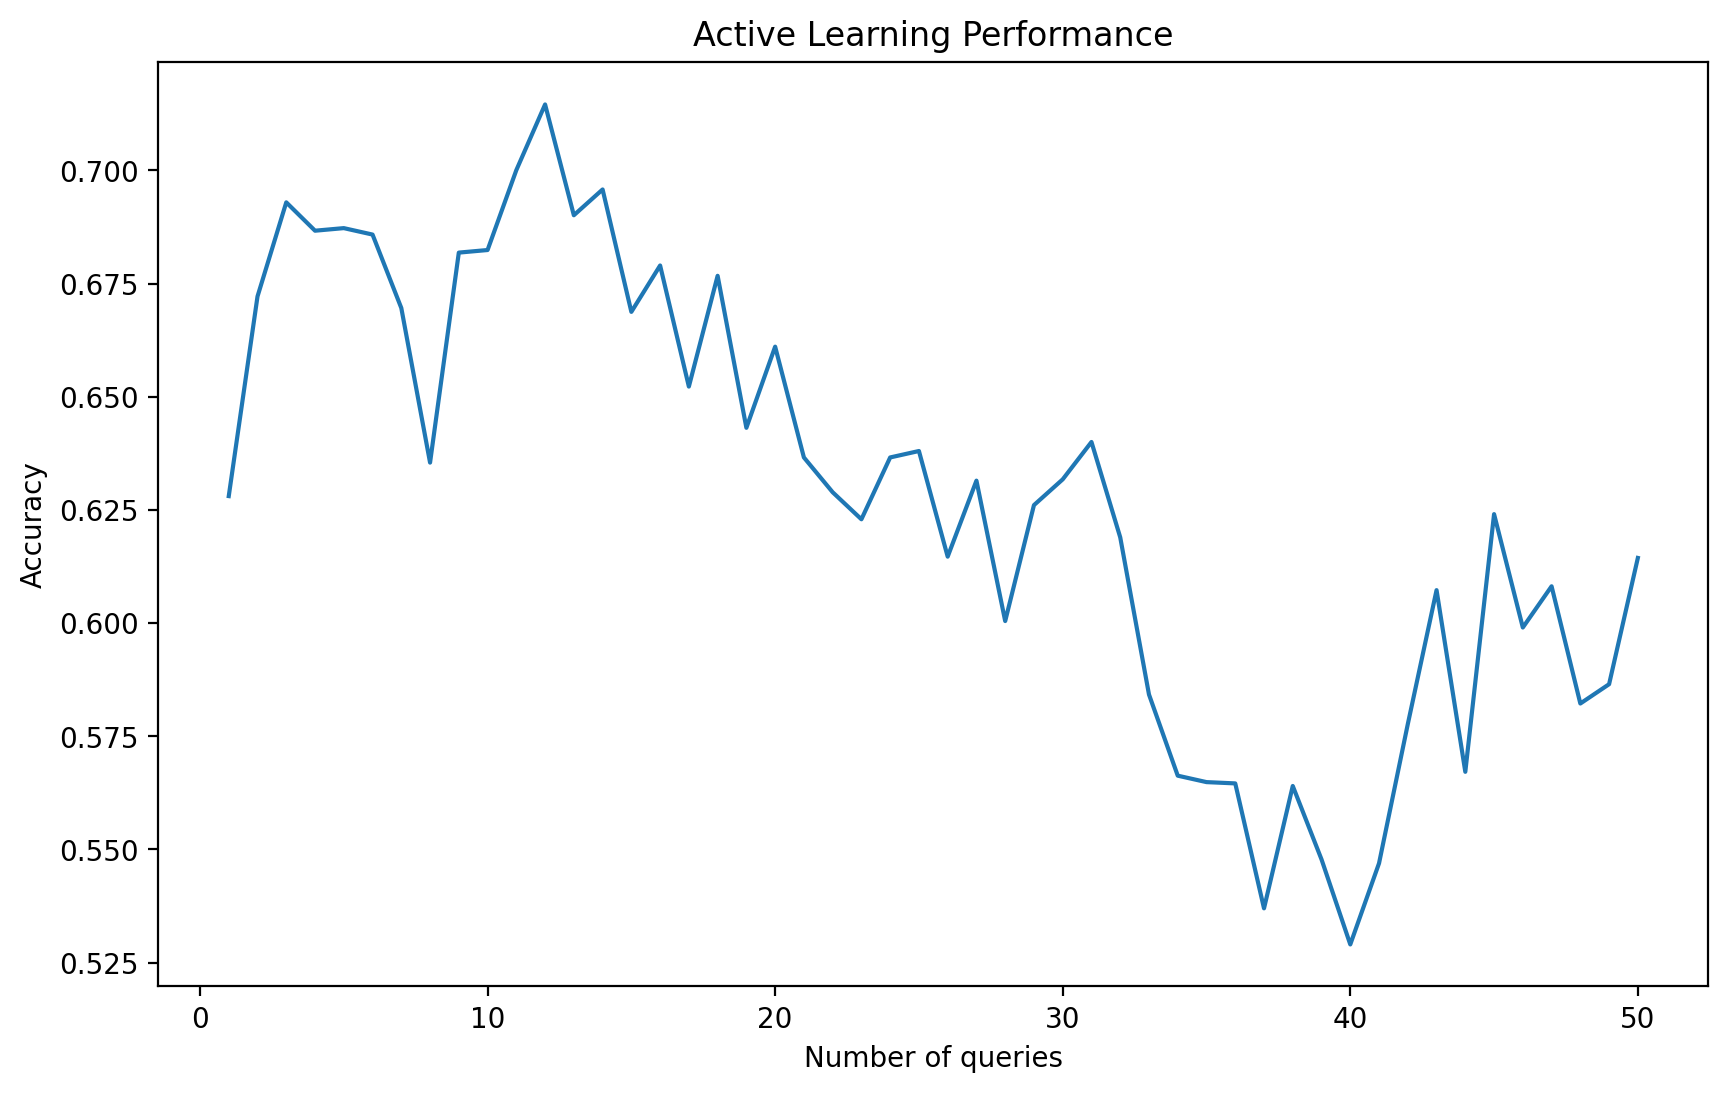

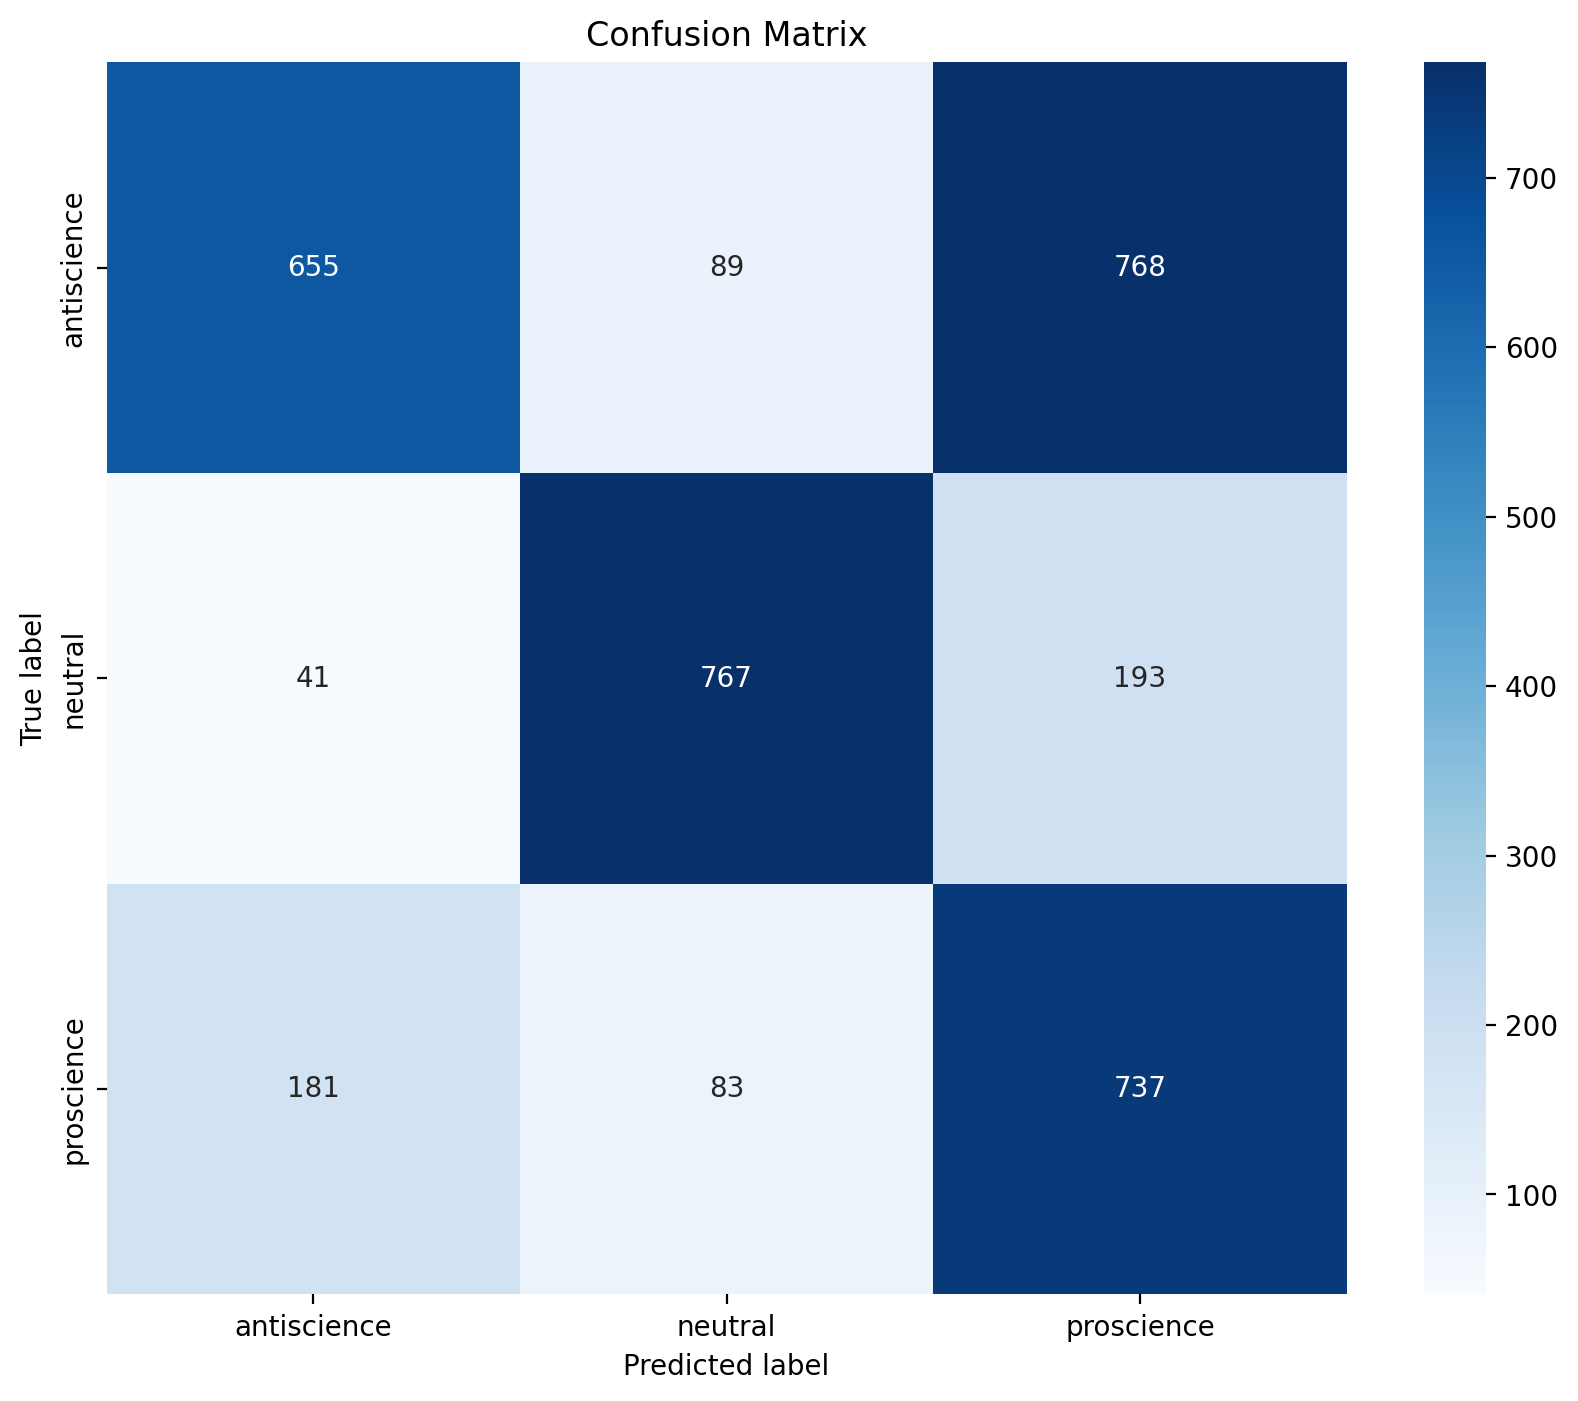

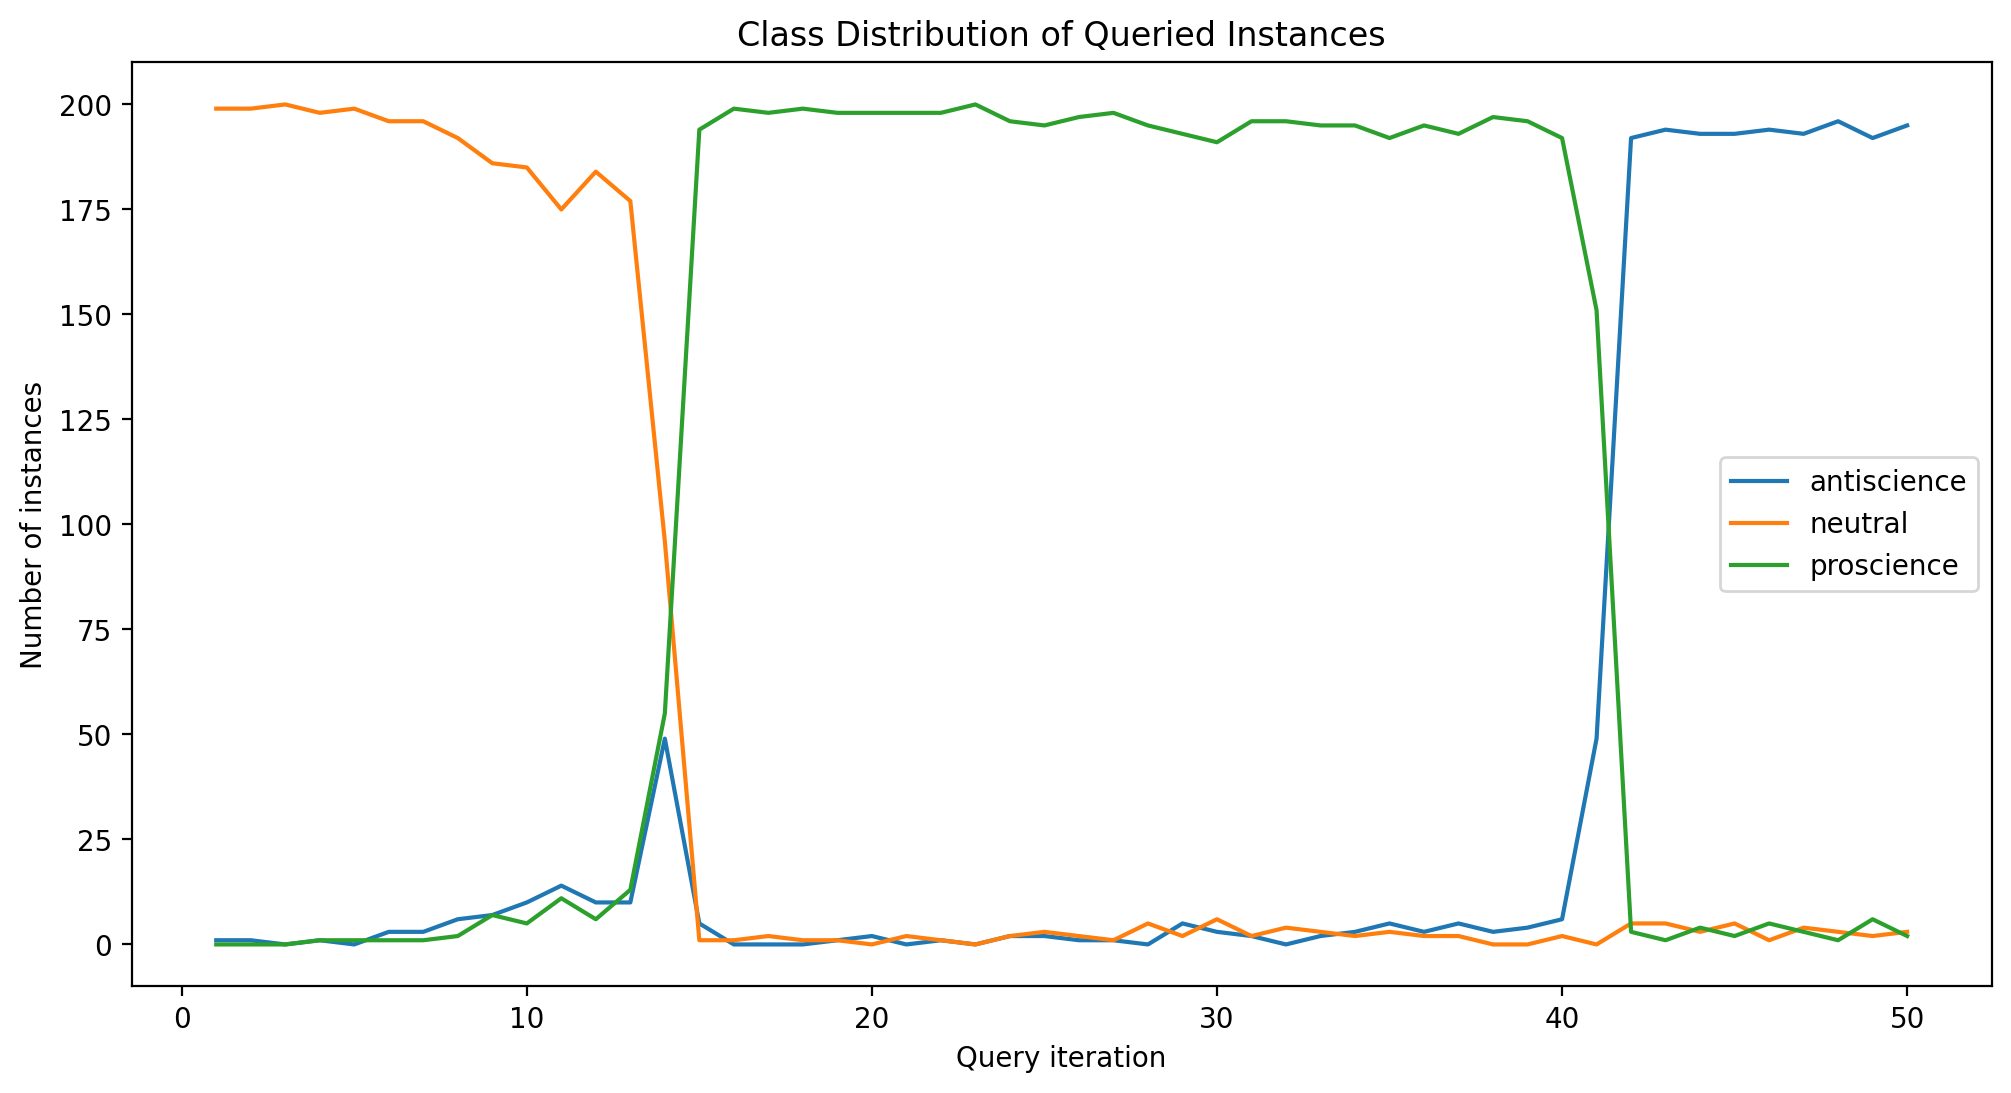

2024-09-09 19:42:27,350 - INFO - 
Additional Information:
2024-09-09 19:42:27,350 - INFO - Total number of queries: 50
2024-09-09 19:42:27,350 - INFO - Final accuracy: 0.6144
2024-09-09 19:42:27,350 - INFO - Total instances queried: 500


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging
from IPython.display import display, HTML

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TweetClassificationPipeline:
    def __init__(self, train_file, test_file, embedding_col='embedding', label_col='final_classification', 
                 initial_labeled_ratio=0.1, random_state=42):
        self.train_file = train_file
        self.test_file = test_file
        self.embedding_col = embedding_col
        self.label_col = label_col
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        logger.info(f"Initialized TweetClassificationPipeline with:")
        logger.info(f"  Train file: {train_file}")
        logger.info(f"  Test file: {test_file}")
        logger.info(f"  Embedding column: {embedding_col}")
        logger.info(f"  Label column: {label_col}")
        logger.info(f"  Initial labeled ratio: {initial_labeled_ratio}")

    def string_to_array(self, s):
        return np.fromstring(s.strip('[]'), sep=' ')

    def load_and_preprocess_data(self):
        logger.info("Loading and preprocessing data...")
        train_data = pd.read_csv(self.train_file)
        test_data = pd.read_csv(self.test_file)
        
        logger.info(f"Train data shape: {train_data.shape}")
        logger.info(f"Test data shape: {test_data.shape}")

        # Convert string embeddings to numpy arrays
        train_data[self.embedding_col] = train_data[self.embedding_col].apply(self.string_to_array)
        test_data[self.embedding_col] = test_data[self.embedding_col].apply(self.string_to_array)

        # Encode labels
        all_labels = pd.concat([train_data[self.label_col], test_data[self.label_col]])
        self.le.fit(all_labels)
        train_data['encoded_label'] = self.le.transform(train_data[self.label_col])
        test_data['encoded_label'] = self.le.transform(test_data[self.label_col])
        
        logger.info(f"Number of classes: {len(self.le.classes_)}")
        logger.info(f"Classes: {', '.join(self.le.classes_)}")

        # Prepare data
        X_train = np.stack(train_data[self.embedding_col].values)
        y_train = train_data['encoded_label'].values
        X_test = np.stack(test_data[self.embedding_col].values)
        y_test = test_data['encoded_label'].values

        # Split train data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            stratify=y_train, random_state=self.random_state
        )
        
        logger.info(f"Initial labeled set size: {len(X_initial)}")
        logger.info(f"Pool size: {len(X_pool)}")
        logger.info(f"Test set size: {len(X_test)}")

        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def create_committee(self):
        logger.info("Creating committee of models...")
        # Initialize base models
        rf_model = RandomForestClassifier(n_estimators=100, random_state=self.random_state, n_jobs=-1)
        xgb_model = XGBClassifier(n_estimators=100, random_state=self.random_state, n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
        svm_model = SVC(probability=True, random_state=self.random_state)

        # Create ActiveLearners
        learner_rf = ActiveLearner(estimator=rf_model, query_strategy=entropy_sampling)
        learner_xgb = ActiveLearner(estimator=xgb_model, query_strategy=entropy_sampling)
        learner_svm = ActiveLearner(estimator=svm_model, query_strategy=entropy_sampling)

        # Create Committee
        committee = Committee(learner_list=[learner_rf, learner_xgb, learner_svm], query_strategy=self.uncertainty_diversity_sampling)
        
        logger.info("Committee created with RandomForest, XGBoost, and SVM models")
        return committee

    def uncertainty_diversity_sampling(self, committee, X_pool, n_instances=200, alpha=0.5):
        # Calculate uncertainty scores
        uncertainties = entropy_sampling(committee, X_pool)[0]
        
        # Calculate diversity scores
        committee_embeddings = np.mean([learner.estimator.predict_proba(X_pool) for learner in committee.learner_list], axis=0)
        diversity_scores = cdist(committee_embeddings, committee_embeddings).mean(axis=1)
        
        # Normalize scores
        uncertainties = (uncertainties - uncertainties.min()) / (uncertainties.max() - uncertainties.min() + 1e-8)
        diversity_scores = (diversity_scores - diversity_scores.min()) / (diversity_scores.max() - diversity_scores.min() + 1e-8)
        
        # Combine uncertainty and diversity scores
        combined_scores = alpha * uncertainties + (1 - alpha) * diversity_scores
        
        # Get indices of instances with highest combined scores
        query_idx = np.argpartition(combined_scores, -n_instances)[-n_instances:]
        
        return query_idx, X_pool[query_idx]

    def run_active_learning(self, n_queries=50):
        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()
        committee = self.create_committee()

        # Initialize committee
        committee.fit(X_initial, y_initial)
        logger.info("Committee initialized with initial labeled set")

        performance_history = []
        class_distribution = []

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            # Query instances
            query_idx, _ = committee.query(X_pool, n_instances=200)
            
            # Teach committee
            committee.teach(X_pool[query_idx], y_pool[query_idx])
            
            # Update class distribution
            current_distribution = np.bincount(y_pool[query_idx], minlength=len(self.le.classes_))
            class_distribution.append(current_distribution)
            
            # Remove queried instances from pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            # Evaluate performance
            y_pred = committee.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            if (iteration + 1) % 10 == 0:
                logger.info(f"Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}")

        logger.info("Active learning completed")
        return committee, performance_history, class_distribution

    def plot_learning_curve(self, performance_history):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(performance_history) + 1), performance_history)
        plt.title('Active Learning Performance')
        plt.xlabel('Number of queries')
        plt.ylabel('Accuracy')
        plt.show()

    def plot_confusion_matrix(self, committee, X_test, y_test):
        y_pred = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.show()

    def plot_class_distribution(self, class_distribution):
        class_distribution = np.array(class_distribution)
        plt.figure(figsize=(12, 6))
        for i, class_name in enumerate(self.le.classes_):
            plt.plot(range(1, len(class_distribution) + 1), class_distribution[:, i], label=class_name)
        plt.title('Class Distribution of Queried Instances')
        plt.xlabel('Query iteration')
        plt.ylabel('Number of instances')
        plt.legend()
        plt.show()

    def run_pipeline(self):
        committee, performance_history, class_distribution = self.run_active_learning()
        
        # Final evaluation
        _, _, _, _, X_test, y_test = self.load_and_preprocess_data()
        y_pred = committee.predict(X_test)
        
        logger.info("\nFinal Classification Report:")
        report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        print(report)
        
        # Display plots
        self.plot_learning_curve(performance_history)
        self.plot_confusion_matrix(committee, X_test, y_test)
        self.plot_class_distribution(class_distribution)
        
        # Additional useful information
        logger.info("\nAdditional Information:")
        logger.info(f"Total number of queries: {len(performance_history)}")
        logger.info(f"Final accuracy: {performance_history[-1]:.4f}")
        logger.info(f"Total instances queried: {len(performance_history) * 10}")
        
        return committee, performance_history, class_distribution

def run_tweet_classification(train_file, test_file):
    pipeline = TweetClassificationPipeline(train_file, test_file)
    committee, performance_history, class_distribution = pipeline.run_pipeline()
    
    return {
        'committee': committee,
        'performance_history': performance_history,
        'class_distribution': class_distribution,
        'label_encoder': pipeline.le
    }

# Example usage
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

results = run_tweet_classification(train_file="train_data_with_sentencetrans_embeddings.csv",
                                   test_file="test_data_with_sentencetrans_embeddings.csv")

# Only XGBOOST (test) (acc: 0.81)

2024-09-21 16:20:12,559 - INFO - Initializing DualDatasetXGBoostPipeline
2024-09-21 16:20:12,560 - INFO - SBERT data file: sbert_llama_classifications.csv
2024-09-21 16:20:12,560 - INFO - Original data file: llama_cleaned_final_classification.csv
2024-09-21 16:20:12,560 - INFO - Embedding column: dense_embedding
2024-09-21 16:20:12,560 - INFO - Label column: cleaned_classification
2024-09-21 16:20:12,561 - INFO - Test size: 0.2
2024-09-21 16:20:12,561 - INFO - Random state: 42
2024-09-21 16:20:12,562 - INFO - Starting DualDatasetXGBoostPipeline
2024-09-21 16:20:12,563 - INFO - Loading and preprocessing data from sbert_llama_classifications.csv...
2024-09-21 16:20:24,332 - INFO - Data loaded and preprocessed in 11.77 seconds
2024-09-21 16:20:24,332 - INFO - Data shape: (79763, 10)
2024-09-21 16:20:24,334 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-21 16:20:24,335 - INFO - Preparing data for training
2024-09-21 16:20:24,692 - INFO - Training set shape: (63810,

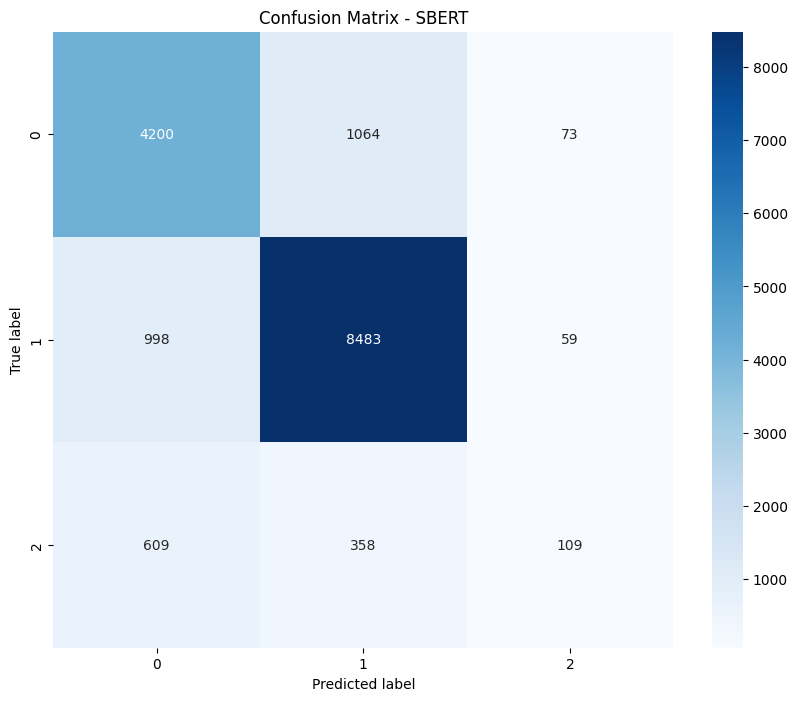

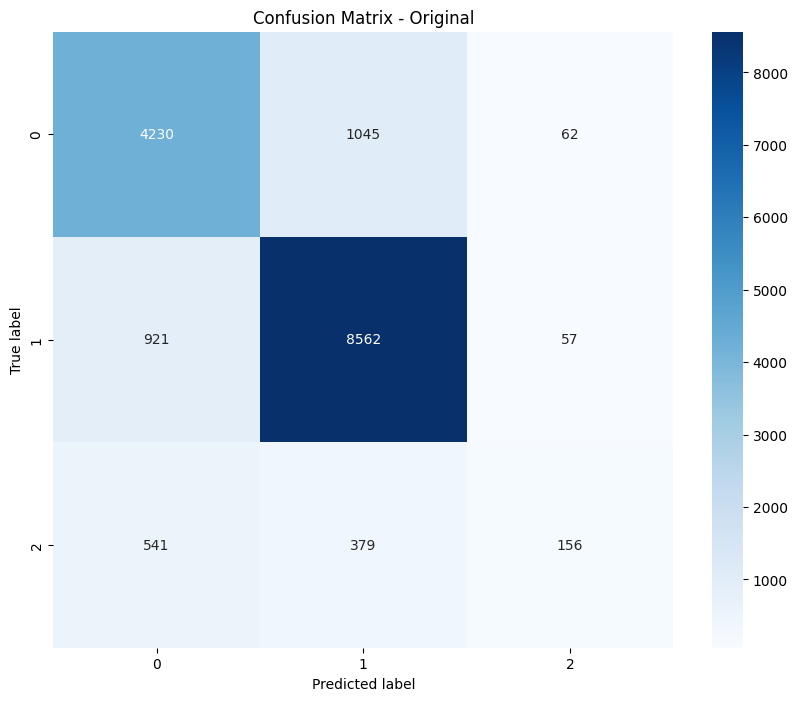

In [21]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class DualDatasetXGBoostPipeline:
    def __init__(self, sbert_file: str, original_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.sbert_file = sbert_file
        self.original_file = original_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing DualDatasetXGBoostPipeline")
        logger.info(f"SBERT data file: {self.sbert_file}")
        logger.info(f"Original data file: {self.original_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _load_and_preprocess_data(self, file_path: str, is_sbert: bool) -> pd.DataFrame:
        start_time = time.time()
        logger.info(f"Loading and preprocessing data from {file_path}...")
        data = pd.read_csv(file_path)
        
        # Convert embeddings to numpy arrays
        if is_sbert:
            data[self.embedding_column] = data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
        else:
            data[self.embedding_column] = data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {data.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        
        return data, end_time - start_time

    def prepare_data(self, data: pd.DataFrame):
        logger.info("Preparing data for training")
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        logger.info("Training XGBoost model...")
        start_time = time.time()
        
        model = XGBClassifier(objective='multi:softprob', num_class=len(self.le.classes_), random_state=self.random_state)
        model.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, target_names=self.le.classes_)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info("\nClassification Report:")
        logger.info(cr)
        
        return accuracy, cm, cr, train_time

    def plot_confusion_matrix(self, cm, title):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(title)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    def run_pipeline(self):
        logger.info("Starting DualDatasetXGBoostPipeline")
        
        # SBERT dataset
        sbert_data, sbert_load_time = self._load_and_preprocess_data(self.sbert_file, is_sbert=True)
        X_train, X_test, y_train, y_test = self.prepare_data(sbert_data)
        sbert_start_time = time.time()
        sbert_accuracy, sbert_cm, sbert_cr, sbert_train_time = self.train_and_evaluate(X_train, X_test, y_train, y_test)
        sbert_total_time = time.time() - sbert_start_time
        
        # Original dataset
        original_data, original_load_time = self._load_and_preprocess_data(self.original_file, is_sbert=False)
        X_train, X_test, y_train, y_test = self.prepare_data(original_data)
        original_start_time = time.time()
        original_accuracy, original_cm, original_cr, original_train_time = self.train_and_evaluate(X_train, X_test, y_train, y_test)
        original_total_time = time.time() - original_start_time
        
        # Report results
        logger.info("\n--- SBERT Results ---")
        logger.info(f"Data loading time: {sbert_load_time:.2f} seconds")
        logger.info(f"Pipeline execution time: {sbert_total_time:.2f} seconds")
        logger.info(f"Training time: {sbert_train_time:.2f} seconds")
        logger.info(f"Final accuracy: {sbert_accuracy:.4f}")
        
        logger.info("\n--- Original Results ---")
        logger.info(f"Data loading time: {original_load_time:.2f} seconds")
        logger.info(f"Pipeline execution time: {original_total_time:.2f} seconds")
        logger.info(f"Training time: {original_train_time:.2f} seconds")
        logger.info(f"Final accuracy: {original_accuracy:.4f}")
        
        # Plot confusion matrices
        self.plot_confusion_matrix(sbert_cm, 'Confusion Matrix - SBERT')
        self.plot_confusion_matrix(original_cm, 'Confusion Matrix - Original')

# Example usage
sbert_file = "sbert_llama_classifications.csv"
original_file = "llama_cleaned_final_classification.csv"
embedding_column = "dense_embedding"
label_column = "cleaned_classification"

pipeline = DualDatasetXGBoostPipeline(sbert_file, original_file, embedding_column, label_column)
pipeline.run_pipeline()

In [24]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostMulticlassPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostMulticlassPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        self.data = pd.read_csv(self.data_file)
        
        # Convert embeddings to numpy arrays
        self.data[self.embedding_column] = self.data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))
        
        self.le.fit(self.data[self.label_column])
        self.data['encoded_label'] = self.le.transform(self.data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {self.data.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        X = np.stack(self.data[self.embedding_column].values)
        y = self.data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        # Calculate class weights
        class_counts = np.bincount(y_train)
        total_samples = len(y_train)
        class_weights = total_samples / (len(class_counts) * class_counts)
        self.class_weights = dict(enumerate(class_weights))
        
        logger.info(f"Class weights: {self.class_weights}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        logger.info("Training XGBoost model...")
        start_time = time.time()
        
        model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
        logger.info(f"Cross-validation F1 scores: {cv_scores}")
        logger.info(f"Mean CV F1 score: {np.mean(cv_scores):.4f}")
        
        # Calculate sample weights
        sample_weights = np.array([self.class_weights[label] for label in y_train])
        
        # Fit the model on the entire training set
        model.fit(X_train, y_train, sample_weight=sample_weights)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        self.accuracy = accuracy
        self.f1_score = f1
        self.auc_roc = auc_roc
        self.confusion_matrix = cm
        self.classification_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        self.model = model

    def plot_confusion_matrix(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        logger.info("Confusion matrix saved as 'confusion_matrix.png'")
        plt.close()

    def plot_feature_importance(self):
        feature_importance = self.model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(10, 8))
        plt.barh(range(top_n), feature_importance[sorted_idx][-top_n:])
        plt.yticks(range(top_n), [f"Feature {i}" for i in sorted_idx[-top_n:]])
        plt.xlabel("Feature Importance")
        plt.title("Top 20 Most Important Features")
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        logger.info("Feature importance plot saved as 'feature_importance.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting XGBoostMulticlassPipeline")
        start_time = time.time()
        
        self.train_and_evaluate()
        self.plot_confusion_matrix()
        self.plot_feature_importance()
        
        end_time = time.time()
        logger.info(f"Pipeline completed in {end_time - start_time:.2f} seconds")
        logger.info(f"Final accuracy: {self.accuracy:.4f}")
        logger.info(f"Final F1 score: {self.f1_score:.4f}")
        logger.info(f"Final AUC-ROC score: {self.auc_roc:.4f}")


data_file = "llama_cleaned_final_classification.csv"
embedding_column = "dense_embedding"
label_column = "cleaned_classification"

pipeline = XGBoostMulticlassPipeline(data_file, embedding_column, label_column)
pipeline.run_pipeline()

2024-09-21 16:30:25,223 - INFO - Initializing XGBoostMulticlassPipeline
2024-09-21 16:30:25,224 - INFO - Data file: llama_cleaned_final_classification.csv
2024-09-21 16:30:25,225 - INFO - Embedding column: dense_embedding
2024-09-21 16:30:25,226 - INFO - Label column: cleaned_classification
2024-09-21 16:30:25,227 - INFO - Test size: 0.2
2024-09-21 16:30:25,227 - INFO - Random state: 42
2024-09-21 16:30:25,228 - INFO - Loading and preprocessing data...
2024-09-21 16:30:40,923 - INFO - Data loaded and preprocessed in 15.70 seconds
2024-09-21 16:30:40,924 - INFO - Data shape: (79763, 11)
2024-09-21 16:30:40,925 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-21 16:30:41,000 - INFO - Starting XGBoostMulticlassPipeline
2024-09-21 16:30:41,001 - INFO - Preparing data for training
2024-09-21 16:30:41,272 - INFO - Training set shape: (63810, 384)
2024-09-21 16:30:41,272 - INFO - Test set shape: (15953, 384)
2024-09-21 16:30:41,275 - INFO - Class weights: {0: 0.99634626

# XGBoost with Distance and cosine similarity + SMOOTE (NO AL)
- performance very low but highest recall

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
import logging
import time

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class DistanceFeaturePipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.le = LabelEncoder()
        
    def compute_distance_features(self):
        logger.info("Starting Distance Feature Pipeline")
        start_time = time.time()
        
        # Load data
        logger.info("Loading data...")
        data = pd.read_csv(self.data_file)
        data[self.embedding_column] = data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))
        
        # Encode labels
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        # Extract embeddings and labels
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        # Compute class centroids
        class_centroids = np.array([X[y == i].mean(axis=0) for i in range(len(self.le.classes_))])
        
        # Compute distances to class centroids
        logger.info("Computing distances to class centroids...")
        class_distances = cosine_similarity(X, class_centroids)
        
        # Add distance features to the dataframe
        for i, class_name in enumerate(self.le.classes_):
            data[f'distance_to_{class_name}'] = class_distances[:, i]
        
        end_time = time.time()
        logger.info(f"Distance features computed in {end_time - start_time:.2f} seconds")
        
        # Save the updated dataframe
        output_file = 'data_with_distance_features.csv'
        data.to_csv(output_file, index=False)
        logger.info(f"Data with distance features saved to {output_file}")
        
        return output_file

# Usage:
distance_pipeline = DistanceFeaturePipeline("llama_cleaned_final_classification.csv", "dense_embedding", "cleaned_classification")
new_data_file = distance_pipeline.compute_distance_features()

2024-09-21 18:38:28,732 - INFO - Starting Distance Feature Pipeline
2024-09-21 18:38:28,733 - INFO - Loading data...
2024-09-21 18:38:44,485 - INFO - Computing distances to class centroids...
2024-09-21 18:38:44,679 - INFO - Distance features computed in 15.95 seconds
2024-09-21 18:40:25,137 - INFO - Data with distance features saved to data_with_distance_features.csv


In [19]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostWeightedCVPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostWeightedCVPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        self.data = pd.read_csv(self.data_file)
        
        # Convert embeddings to numpy arrays
        self.data[self.embedding_column] = self.data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
        
        # Identify distance columns
        self.distance_columns = [col for col in self.data.columns if col.startswith('distance_to_')]
        logger.info(f"Distance columns found: {self.distance_columns}")
        
        # Scale distance features
        self.data[self.distance_columns] = self.scaler.fit_transform(self.data[self.distance_columns])
        
        self.le.fit(self.data[self.label_column])
        self.data['encoded_label'] = self.le.transform(self.data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {self.data.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        
        # Combine embedding and distance features
        X_embeddings = np.stack(self.data[self.embedding_column].values)
        X_distances = self.data[self.distance_columns].values
        X = np.hstack([X_embeddings, X_distances])
        y = self.data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        # Calculate class weights
        class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
        self.class_weights = dict(enumerate(class_weights))
        
        logger.info(f"Class weights: {self.class_weights}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        logger.info("Training XGBoost model...")
        start_time = time.time()
        
        model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            use_label_encoder=False,
            eval_metric='mlogloss',
            scale_pos_weight=self.class_weights
        )
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
        logger.info(f"Cross-validation F1 scores: {cv_scores}")
        logger.info(f"Mean CV F1 score: {np.mean(cv_scores):.4f}")
        
        # Fit the model on the entire training set
        model.fit(X_train, y_train)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        self.accuracy = accuracy
        self.f1_score = f1
        self.auc_roc = auc_roc
        self.confusion_matrix = cm
        self.classification_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        self.model = model

    def plot_confusion_matrix(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig('confusion_matrix_weighted.png')
        logger.info("Confusion matrix saved as 'confusion_matrix_weighted.png'")
        plt.close()

    def plot_feature_importance(self):
        feature_importance = self.model.feature_importances_
        feature_names = [f"Emb_{i}" for i in range(len(self.data[self.embedding_column].iloc[0]))] + self.distance_columns
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(12, 8))
        plt.barh([x[0] for x in sorted_features[:top_n]], [x[1] for x in sorted_features[:top_n]])
        plt.xlabel("Feature Importance")
        plt.title("Top 20 Most Important Features")
        plt.tight_layout()
        plt.savefig('feature_importance_weighted.png')
        logger.info("Feature importance plot saved as 'feature_importance_weighted.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting XGBoostWeightedCVPipeline")
        start_time = time.time()
        
        self.train_and_evaluate()
        self.plot_confusion_matrix()
        self.plot_feature_importance()
        
        end_time = time.time()
        logger.info(f"Pipeline completed in {end_time - start_time:.2f} seconds")
        logger.info(f"Final accuracy: {self.accuracy:.4f}")
        logger.info(f"Final F1 score: {self.f1_score:.4f}")
        logger.info(f"Final AUC-ROC score: {self.auc_roc:.4f}")

# Usage
data_file = 'sbert_data_with_distance_features.csv'

xgboost_pipeline = XGBoostWeightedCVPipeline(data_file, "dense_embedding", "cleaned_classification")
xgboost_pipeline.run_pipeline()

2024-09-22 10:41:49,370 - INFO - Initializing XGBoostWeightedCVPipeline
2024-09-22 10:41:49,370 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-22 10:41:49,370 - INFO - Embedding column: dense_embedding
2024-09-22 10:41:49,370 - INFO - Label column: cleaned_classification
2024-09-22 10:41:49,370 - INFO - Test size: 0.2
2024-09-22 10:41:49,370 - INFO - Random state: 42
2024-09-22 10:41:49,370 - INFO - Loading and preprocessing data...
2024-09-22 10:42:00,453 - INFO - Distance columns found: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-22 10:42:00,469 - INFO - Data loaded and preprocessed in 11.10 seconds
2024-09-22 10:42:00,469 - INFO - Data shape: (79763, 13)
2024-09-22 10:42:00,469 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-22 10:42:00,520 - INFO - Starting XGBoostWeightedCVPipeline
2024-09-22 10:42:00,520 - INFO - Preparing data for training
2024-09-22 10:42:00,820 - INFO - Training set shape: (638

# XGBoost with AL (and smote better AL performances so far, but no cv and weights...but good performances. XGB without AL is still better)
- To note: cross validation and class weights has better recall on proscience.
- To try: same code but with weights.
- To try: same code but with weights and the centroid distance.
- Also compute AUC-ROC -- highest so far is 0.89 with no AL but weifhts and kfold stratificaiton.

2024-09-21 18:08:24,853 - INFO - Initializing XGBoostActiveLearningPipeline
2024-09-21 18:08:24,854 - INFO - Data file: llama_cleaned_final_classification.csv
2024-09-21 18:08:24,855 - INFO - Embedding column: dense_embedding
2024-09-21 18:08:24,855 - INFO - Label column: cleaned_classification
2024-09-21 18:08:24,856 - INFO - Test size: 0.2
2024-09-21 18:08:24,856 - INFO - Initial labeled ratio: 0.3
2024-09-21 18:08:24,857 - INFO - Random state: 42
2024-09-21 18:08:24,870 - INFO - Starting XGBoost active learning pipeline
2024-09-21 18:08:24,870 - INFO - Loading and preprocessing data
2024-09-21 18:08:43,704 - INFO - Data loaded and preprocessed in 18.83 seconds
2024-09-21 18:08:43,705 - INFO - Original data shape: (79763, 384)
2024-09-21 18:08:43,705 - INFO - Resampled training data shape: (114480, 384)
2024-09-21 18:08:43,706 - INFO - Test data shape: (15953, 384)
2024-09-21 18:08:43,706 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-21 18:08:43,708 - INFO -

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2024-09-21 18:10:47,826 - INFO - XGBoost - Iteration 5/50: Accuracy = 0.7699
2024-09-21 18:12:55,528 - INFO - XGBoost - Iteration 10/50: Accuracy = 0.7753
2024-09-21 18:15:10,753 - INFO - XGBoost - Iteration 15/50: Accuracy = 0.7758
2024-09-21 18:17:32,611 - INFO - XGBoost - Iteration 20/50: Accuracy = 0.7778
2024-09-21 18:20:54,401 - INFO - XGBoost - Iteration 25/50: Accuracy = 0.7770
2024-09-21 18:24:04,580 - INFO - XGBoost - Iteration 30/50: Accuracy = 0.7767
2024-09-21 18:27:24,638 - INFO - XGBoost - Iteration 35/50: Accuracy = 0.7803
2024-09-21 18:30:17,056 - INFO - XGBoost - Early stopping at iteration 39 due to no improvement
2024-09-21 18:30:17,057 - INFO - XGBoost - Active learning completed in 1293.20 seconds
2024-09-21 18:30:17,058 - INFO - XGBoost - Final accuracy: 0.7764
2024-09-21 18:30:17,200 - INFO - XGBoost Active Learning Pipeline completed in 1312.33 seconds
2024-09-21 18:30:17,201 - INFO - XGBoost - Initial accuracy: 0.7681, Final accuracy: 0.7764
2024-09-21 18:30:1

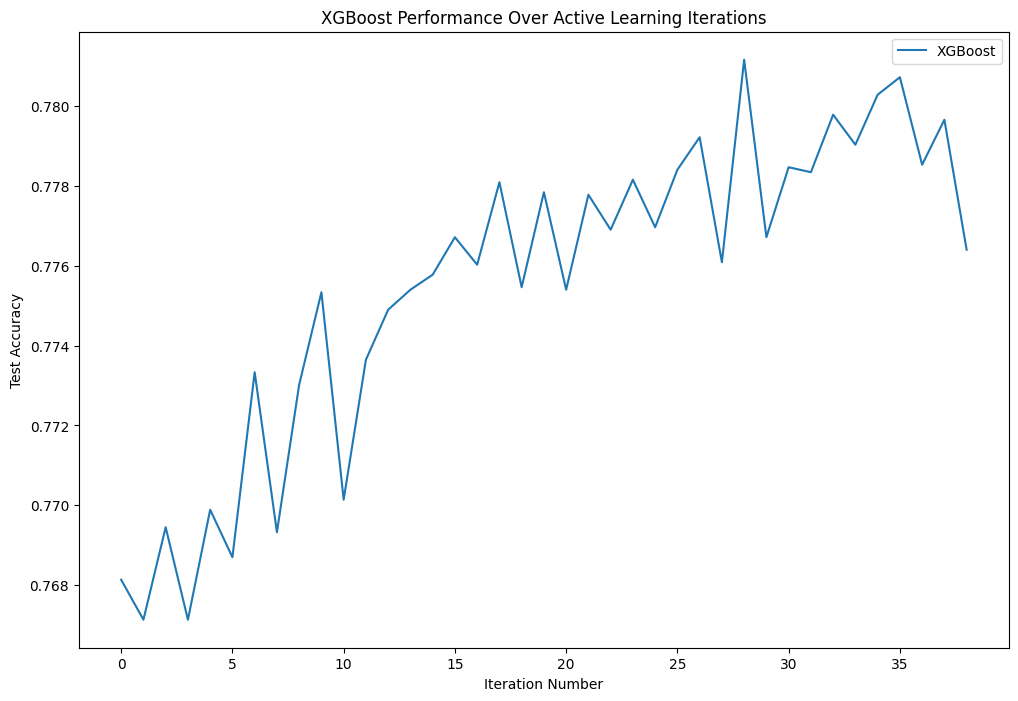

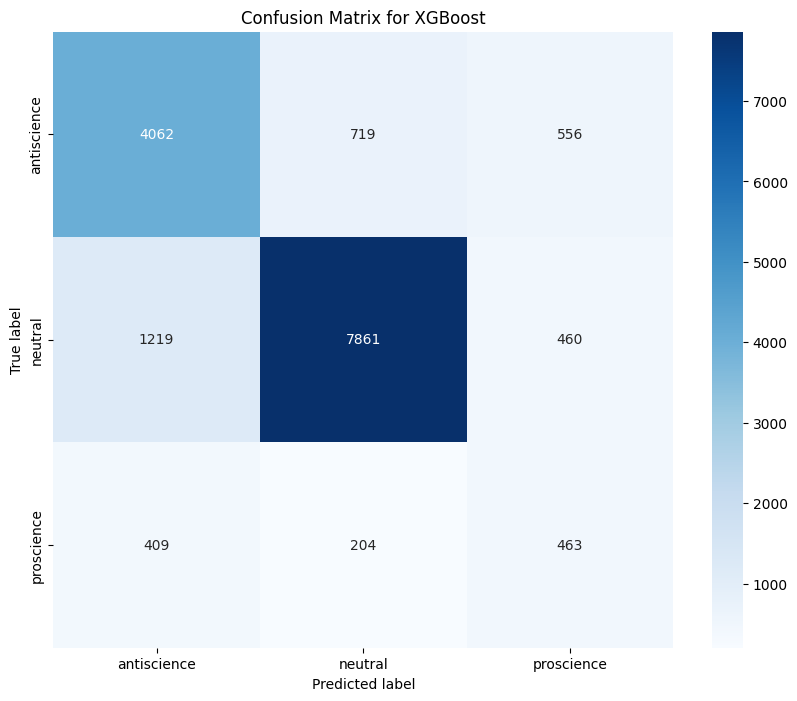

              precision    recall  f1-score   support

 antiscience       0.71      0.76      0.74      5337
     neutral       0.89      0.82      0.86      9540
  proscience       0.31      0.43      0.36      1076

    accuracy                           0.78     15953
   macro avg       0.64      0.67      0.65     15953
weighted avg       0.80      0.78      0.78     15953



In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, initial_labeled_ratio: float = 0.3, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.le = LabelEncoder()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")

    def load_and_preprocess_data(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        # Load data in chunks
        chunks = pd.read_csv(self.data_file, chunksize=10000)
        data_list = []
        for chunk in chunks:
            chunk[self.embedding_column] = chunk[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=','))
            data_list.append(chunk)
        data = pd.concat(data_list)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X = np.stack(data[self.embedding_column].values)
        y = data['encoded_label'].values
        
        # Split into train and test first
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        # Apply SMOTE only to the training data
        smote = SMOTE(random_state=self.random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Split the resampled training data into initial labeled set and pool
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train_resampled, y_train_resampled, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train_resampled
        )
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Original data shape: {X.shape}")
        logger.info(f"Resampled training data shape: {X_train_resampled.shape}")
        logger.info(f"Test data shape: {X_test.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution in resampled training set: {np.bincount(y_train_resampled)}")
        logger.info(f"Class distribution in test set: {np.bincount(y_test)}")
        
        return X_initial, y_initial, X_pool, y_pool, X_test, y_test

    def train_with_active_learning(self, X_initial: np.ndarray, y_initial: np.ndarray, 
                                   X_pool: np.ndarray, y_pool: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                                   n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], np.ndarray]:
        logger.info("Starting active learning with XGBoost")
        start_time = time.time()

        # Initialize XGBoost model
        xgb_model = XGBClassifier(
            objective='multi:softprob',
            num_class=len(self.le.classes_),
            random_state=self.random_state,
            n_jobs=-1,  # Use all available cores
            learning_rate=0.1,
            n_estimators=100,
            max_depth=6,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8
        )

        # Create active learner
        learner = ActiveLearner(
            estimator=xgb_model,
            X_training=X_initial,
            y_training=y_initial,
            query_strategy=entropy_sampling
        )

        performance_history = []
        best_accuracy = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = learner.query(X_pool, n_instances=n_instances_per_query)
            
            learner.teach(X_pool[query_idx], y_pool[query_idx])
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = learner.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            performance_history.append(accuracy)
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                iterations_without_improvement = 0
                self.best_model = learner
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"XGBoost - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"XGBoost - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"XGBoost - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"XGBoost - Final accuracy: {performance_history[-1]:.4f}")

        y_pred_final = learner.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "XGBoost", performance_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting XGBoost active learning pipeline")
        start_time = time.time()

        X_initial, y_initial, X_pool, y_pool, X_test, y_test = self.load_and_preprocess_data()

        model_name, performance_history, cm = self.train_with_active_learning(
            X_initial, y_initial, X_pool, y_pool, X_test, y_test
        )

        self.model_performance = {model_name: performance_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"XGBoost Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {performance_history[0]:.4f}, Final accuracy: {performance_history[-1]:.4f}")

        # Generate classification report
        y_pred = self.best_model.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=model_name)
        plt.title('XGBoost Performance Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Test Accuracy')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Example usage in a notebook:
pipeline = XGBoostActiveLearningPipeline("llama_cleaned_final_classification.csv", "dense_embedding", "cleaned_classification")
results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrix()
print(class_report)

## XGB AL (no distance, but with new technique for sampling)

# New Try with AL 

- Need to merge the best of the processes: 
1. Try with simple models (Xgb, Logistic, Gaussian) + smote and keyfold and additional features. Here add auc-roc as a metric. 
2. Try different sampling techniques??? entroby is faster tho...should need to combine both uncertainity and distance. Need to explore. 
3. Should i try to implement a bayesian??????
4. Need to try UDA with bert on the sbert dataset (masking some of the labels). Try to to data aug with translate-back-translate.

In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import logging
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class XGBoostWeightedCVPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 test_size: float = 0.2, random_state: int = 42):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        
        self._log_init_info()
        self._load_and_preprocess_data()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing XGBoostWeightedCVPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Random state: {self.random_state}")

    def _load_and_preprocess_data(self) -> None:
        start_time = time.time()
        logger.info("Loading and preprocessing data...")
        self.data = pd.read_csv(self.data_file)
        
        # Convert embeddings to numpy arrays
        self.data[self.embedding_column] = self.data[self.embedding_column].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
        
        # Identify distance columns
        self.distance_columns = [col for col in self.data.columns if col.startswith('distance_to_')]
        logger.info(f"Distance columns found: {self.distance_columns}")
        
        # Scale distance features
        self.data[self.distance_columns] = self.scaler.fit_transform(self.data[self.distance_columns])
        
        self.le.fit(self.data[self.label_column])
        self.data['encoded_label'] = self.le.transform(self.data[self.label_column])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {self.data.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")

    def prepare_data(self):
        logger.info("Preparing data for training")
        
        # Combine embedding and distance features
        X_embeddings = np.stack(self.data[self.embedding_column].values)
        X_distances = self.data[self.distance_columns].values
        X = np.hstack([X_embeddings, X_distances])
        y = self.data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        logger.info(f"Training set shape: {X_train.shape}")
        logger.info(f"Test set shape: {X_test.shape}")
        
        # Calculate class weights
        class_weights = len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
        self.class_weights = dict(enumerate(class_weights))
        
        logger.info(f"Class weights: {self.class_weights}")
        
        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self):
        X_train, X_test, y_train, y_test = self.prepare_data()
        
        logger.info("Training XGBoost model...")
        start_time = time.time()
        
        # Prepare sample weights for multiclass
        sample_weights = np.array([self.class_weights[y] for y in y_train])
        
        model = XGBClassifier(
            objective='multi:softprob', 
            num_class=len(self.le.classes_), 
            random_state=self.random_state,
            eval_metric='mlogloss'
        )
        
        # Perform cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
        logger.info(f"Cross-validation F1 scores: {cv_scores}")
        logger.info(f"Mean CV F1 score: {np.mean(cv_scores):.4f}")
        
        # Fit the model on the entire training set with sample weights
        model.fit(X_train, y_train, sample_weight=sample_weights)
        
        train_time = time.time() - start_time
        logger.info(f"Model trained in {train_time:.2f} seconds")
        
        logger.info("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        cm = confusion_matrix(y_test, y_pred)
        
        logger.info(f"Test Accuracy: {accuracy:.4f}")
        logger.info(f"Macro F1 Score: {f1:.4f}")
        logger.info(f"AUC-ROC Score: {auc_roc:.4f}")
        logger.info("\nClassification Report:")
        logger.info(classification_report(y_test, y_pred, target_names=self.le.classes_))
        
        self.accuracy = accuracy
        self.f1_score = f1
        self.auc_roc = auc_roc
        self.confusion_matrix = cm
        self.classification_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        self.model = model

    def plot_confusion_matrix(self):
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.le.classes_, yticklabels=self.le.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig('confusion_matrix_weighted.png')
        logger.info("Confusion matrix saved as 'confusion_matrix_weighted.png'")
        plt.close()

    def plot_feature_importance(self):
        feature_importance = self.model.feature_importances_
        feature_names = [f"Emb_{i}" for i in range(len(self.data[self.embedding_column].iloc[0]))] + self.distance_columns
        feature_importance_dict = dict(zip(feature_names, feature_importance))
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
        top_n = 20  # Show top 20 features

        plt.figure(figsize=(12, 8))
        plt.barh([x[0] for x in sorted_features[:top_n]], [x[1] for x in sorted_features[:top_n]])
        plt.xlabel("Feature Importance")
        plt.title("Top 20 Most Important Features")
        plt.tight_layout()
        plt.savefig('feature_importance_weighted.png')
        logger.info("Feature importance plot saved as 'feature_importance_weighted.png'")
        plt.close()

    def run_pipeline(self):
        logger.info("Starting XGBoostWeightedCVPipeline")
        start_time = time.time()
        
        self.train_and_evaluate()
        self.plot_confusion_matrix()
        self.plot_feature_importance()
        
        end_time = time.time()
        logger.info(f"Pipeline completed in {end_time - start_time:.2f} seconds")
        logger.info(f"Final accuracy: {self.accuracy:.4f}")
        logger.info(f"Final F1 score: {self.f1_score:.4f}")
        logger.info(f"Final AUC-ROC score: {self.auc_roc:.4f}")

# Usage
data_file = 'sbert_data_with_distance_features.csv'

xgboost_pipeline = XGBoostWeightedCVPipeline(data_file, "dense_embedding", "cleaned_classification")
xgboost_pipeline.run_pipeline()

2024-09-22 10:47:02,279 - INFO - Initializing XGBoostWeightedCVPipeline
2024-09-22 10:47:02,280 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-22 10:47:02,281 - INFO - Embedding column: dense_embedding
2024-09-22 10:47:02,281 - INFO - Label column: cleaned_classification
2024-09-22 10:47:02,282 - INFO - Test size: 0.2
2024-09-22 10:47:02,282 - INFO - Random state: 42
2024-09-22 10:47:02,283 - INFO - Loading and preprocessing data...
2024-09-22 10:47:13,481 - INFO - Distance columns found: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-22 10:47:13,496 - INFO - Data loaded and preprocessed in 11.21 seconds
2024-09-22 10:47:13,496 - INFO - Data shape: (79763, 13)
2024-09-22 10:47:13,496 - INFO - Encoded labels: ['antiscience' 'neutral' 'proscience']
2024-09-22 10:47:13,577 - INFO - Starting XGBoostWeightedCVPipeline
2024-09-22 10:47:13,577 - INFO - Preparing data for training
2024-09-22 10:47:13,912 - INFO - Training set shape: (638

In [10]:
distance = pd.read_csv(r'sbert_data_with_distance_features.csv')
distance.dense_embedding.dtype

dtype('O')

2024-09-22 12:57:21,057 - INFO - Initializing InvPropActiveLearningPipeline
2024-09-22 12:57:21,057 - INFO - Data file: sbert_data_with_distance_features.csv
2024-09-22 12:57:21,057 - INFO - Embedding column: dense_embedding
2024-09-22 12:57:21,057 - INFO - Label column: cleaned_classification
2024-09-22 12:57:21,067 - INFO - Distance columns: ['distance_to_antiscience', 'distance_to_neutral', 'distance_to_proscience']
2024-09-22 12:57:21,067 - INFO - Test size: 0.2
2024-09-22 12:57:21,068 - INFO - Initial labeled ratio: 0.3
2024-09-22 12:57:21,068 - INFO - Random state: 42
2024-09-22 12:57:21,068 - INFO - Number of bins for InvProp: 10
2024-09-22 12:57:21,068 - INFO - Starting InvProp active learning pipeline
2024-09-22 12:57:21,068 - INFO - Loading and preprocessing data
2024-09-22 12:57:32,477 - INFO - Data loaded and preprocessed in 11.41 seconds
2024-09-22 12:57:32,477 - INFO - Data shape: (79763, 387)
2024-09-22 12:57:32,477 - INFO - Encoded labels: ['antiscience' 'neutral' 'pros

Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:57:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

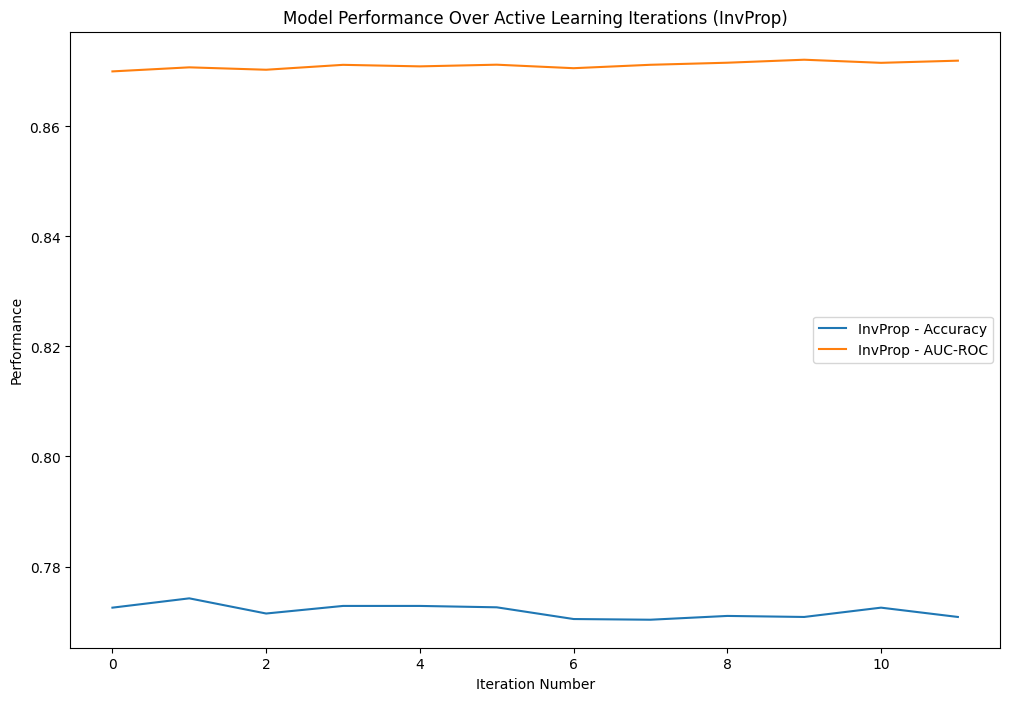

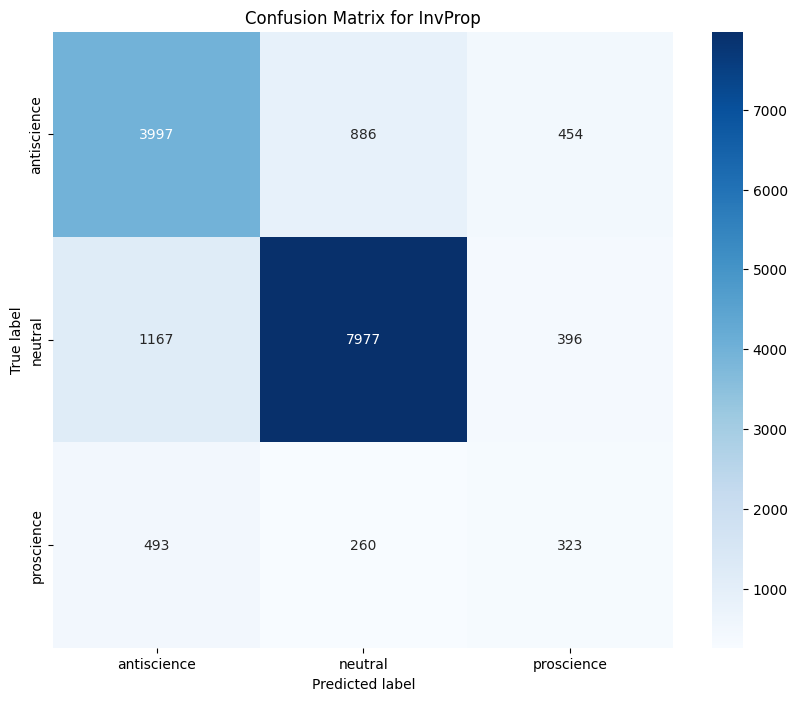

              precision    recall  f1-score   support

 antiscience       0.71      0.75      0.73      5337
     neutral       0.87      0.84      0.85      9540
  proscience       0.28      0.30      0.29      1076

    accuracy                           0.77     15953
   macro avg       0.62      0.63      0.62     15953
weighted avg       0.78      0.77      0.77     15953



In [31]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from modAL.models import ActiveLearner, Committee
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import logging
from typing import List, Tuple, Dict
import time
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class InvPropActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 distance_columns: List[str], test_size: float = 0.2, 
                 initial_labeled_ratio: float = 0.3, random_state: int = 42,
                 n_bins: int = 10):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.distance_columns = distance_columns
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.n_bins = n_bins
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing InvPropActiveLearningPipeline")
        logger.info(f"Data file: {self.data_file}")
        logger.info(f"Embedding column: {self.embedding_column}")
        logger.info(f"Label column: {self.label_column}")
        logger.info(f"Distance columns: {self.distance_columns}")
        logger.info(f"Test size: {self.test_size}")
        logger.info(f"Initial labeled ratio: {self.initial_labeled_ratio}")
        logger.info(f"Random state: {self.random_state}")
        logger.info(f"Number of bins for InvProp: {self.n_bins}")

    @staticmethod
    def parse_embedding(embedding_string):
        return np.fromstring(embedding_string.strip('[]'), sep=' ')

    def load_and_preprocess_data(self):
        logger.info("Loading and preprocessing data")
        start_time = time.time()
        
        data = pd.read_csv(self.data_file)
        
        data[self.embedding_column] = data[self.embedding_column].apply(self.parse_embedding)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X_embeddings = np.stack(data[self.embedding_column].values)
        X_distances = data[self.distance_columns].values
        X = np.hstack((X_embeddings, X_distances))
        
        y = data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        self.scaler.fit(X_train[:, -len(self.distance_columns):])
        X_train[:, -len(self.distance_columns):] = self.scaler.transform(X_train[:, -len(self.distance_columns):])
        X_test[:, -len(self.distance_columns):] = self.scaler.transform(X_test[:, -len(self.distance_columns):])
        
        end_time = time.time()
        logger.info(f"Data loaded and preprocessed in {end_time - start_time:.2f} seconds")
        logger.info(f"Data shape: {X.shape}")
        logger.info(f"Encoded labels: {self.le.classes_}")
        logger.info(f"Class distribution: {np.bincount(y)}")
        
        return X_train, y_train, X_test, y_test
    
    def invprop_query_strategy(self, committee, X_pool, n_instances=1):
        # Get probabilities from each learner
        votes = committee.vote(X_pool)
        
        # Calculate the mean probability across all learners
        if votes.ndim == 3:
            # If votes is 3D (n_learners, n_samples, n_classes)
            mean_probs = np.mean(votes, axis=0)
        elif votes.ndim == 2:
            # If votes is already 2D (n_samples, n_classes)
            mean_probs = votes
        else:
            raise ValueError("Unexpected shape for votes array")

        # Get the maximum probability for each sample
        max_probs = np.max(mean_probs, axis=1)
        
        # Create bins and count samples in each bin
        bins = np.linspace(0, 1, self.n_bins + 1)
        digitized = np.digitize(max_probs, bins) - 1
        bin_counts = np.bincount(digitized, minlength=self.n_bins)
        
        # Calculate inverse propensity weights
        weights = 1 / (bin_counts[digitized] + 1e-10)  # Add small constant to avoid division by zero
        
        # Normalize weights
        weights /= weights.sum()
        
        # Sample instances based on weights
        query_idx = np.random.choice(len(X_pool), size=n_instances, replace=False, p=weights)
        
        return query_idx, mean_probs[query_idx]

    def train_with_invprop(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
            n_queries: int = 50, n_instances_per_query: int = 500) -> Tuple[str, List[float], List[float], np.ndarray]:
        logger.info("Starting active learning with InvProp Query Strategy")
        start_time = time.time()

        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )

        models = [
            XGBClassifier(
                objective='multi:softprob', 
                num_class=len(self.le.classes_), 
                random_state=self.random_state,
                n_jobs=-1,
                tree_method='hist',
                use_label_encoder=False
            ),
            LogisticRegression(random_state=self.random_state, max_iter=1000, n_jobs=-1, multi_class='ovr'),
            GaussianNB()
        ]

        learners = [ActiveLearner(estimator=model, X_training=X_initial, y_training=y_initial) for model in models]
        committee = Committee(learner_list=learners, query_strategy=self.invprop_query_strategy)

        accuracy_history = []
        auc_roc_history = []
        best_performance = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query)
            
            X_teach, y_teach = X_pool[query_idx], y_pool[query_idx]
            
            for learner in committee:
                learner.teach(X_teach, y_teach)
            
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            y_pred = committee.predict(X_test)
            y_pred_proba = committee.predict_proba(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            
            accuracy_history.append(accuracy)
            auc_roc_history.append(auc_roc)
            
            current_performance = (accuracy + auc_roc) / 2  # Average of accuracy and AUC-ROC
            
            if current_performance > best_performance:
                best_performance = current_performance
                iterations_without_improvement = 0
                self.best_committee = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"InvProp - Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"InvProp - Early stopping at iteration {iteration + 1} due to no improvement")
                break

        end_time = time.time()
        logger.info(f"InvProp - Active learning completed in {end_time - start_time:.2f} seconds")
        logger.info(f"InvProp - Final accuracy: {accuracy_history[-1]:.4f}, Final AUC-ROC: {auc_roc_history[-1]:.4f}")

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        return "InvProp", accuracy_history, auc_roc_history, cm

    def run_pipeline(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]], Dict[str, np.ndarray], str]:
        logger.info("Starting InvProp active learning pipeline")
        start_time = time.time()

        X_train, y_train, X_test, y_test = self.load_and_preprocess_data()

        model_name, accuracy_history, auc_roc_history, cm = self.train_with_invprop(X_train, y_train, X_test, y_test)

        self.model_performance = {model_name: accuracy_history}
        self.model_auc_roc = {model_name: auc_roc_history}
        self.confusion_matrices = {model_name: cm}
        
        end_time = time.time()
        logger.info(f"InvProp Active Learning Pipeline completed in {end_time - start_time:.2f} seconds")
        
        logger.info(f"{model_name} - Initial accuracy: {accuracy_history[0]:.4f}, Final accuracy: {accuracy_history[-1]:.4f}")
        logger.info(f"{model_name} - Initial AUC-ROC: {auc_roc_history[0]:.4f}, Final AUC-ROC: {auc_roc_history[-1]:.4f}")

        y_pred = self.best_committee.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)

        return self.model_performance, self.model_auc_roc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=f'{model_name} - Accuracy')
        for model_name, auc_rocs in self.model_auc_roc.items():
            plt.plot(auc_rocs, label=f'{model_name} - AUC-ROC')
        plt.title('Model Performance Over Active Learning Iterations (InvProp)')
        plt.xlabel('Iteration Number')
        plt.ylabel('Performance')
        plt.legend()
        plt.show()

    def plot_confusion_matrices(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Usage
pipeline = InvPropActiveLearningPipeline(
    "sbert_data_with_distance_features.csv",
    "dense_embedding",
    "cleaned_classification",
    ["distance_to_antiscience", "distance_to_neutral", "distance_to_proscience"],
    n_bins=10  # Number of bins for InvProp
)
results, auc_roc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrices()
print(class_report)

2024-09-22 16:43:37,666 - INFO - Initializing ImprovedActiveLearningPipeline
2024-09-22 16:43:37,667 - INFO - Running Improved Active Learning Pipeline
2024-09-22 16:43:37,668 - INFO - Loading and preprocessing data
2024-09-22 16:43:49,851 - INFO - Data shape: (79763, 387)
2024-09-22 16:43:49,889 - INFO - Class distribution: [26685 47700  5378]
2024-09-22 16:43:50,309 - INFO - Starting active learning with entropy + inverse propensity sampling
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Active Learning Progress:   0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\thesis_project\thesis_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\nrosso\Documents\th

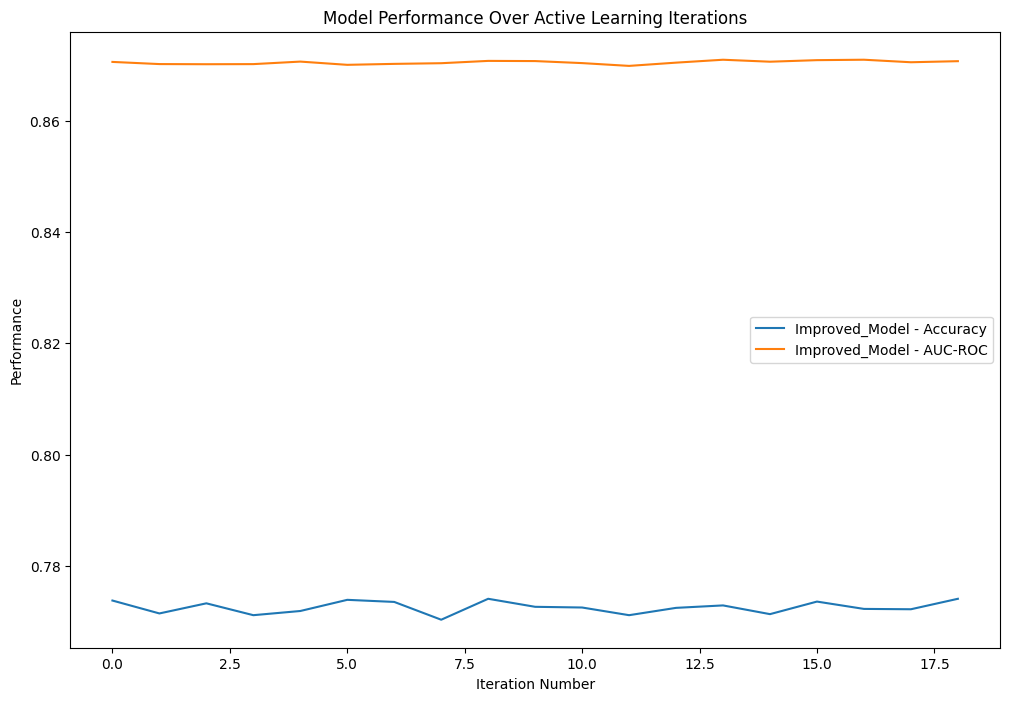

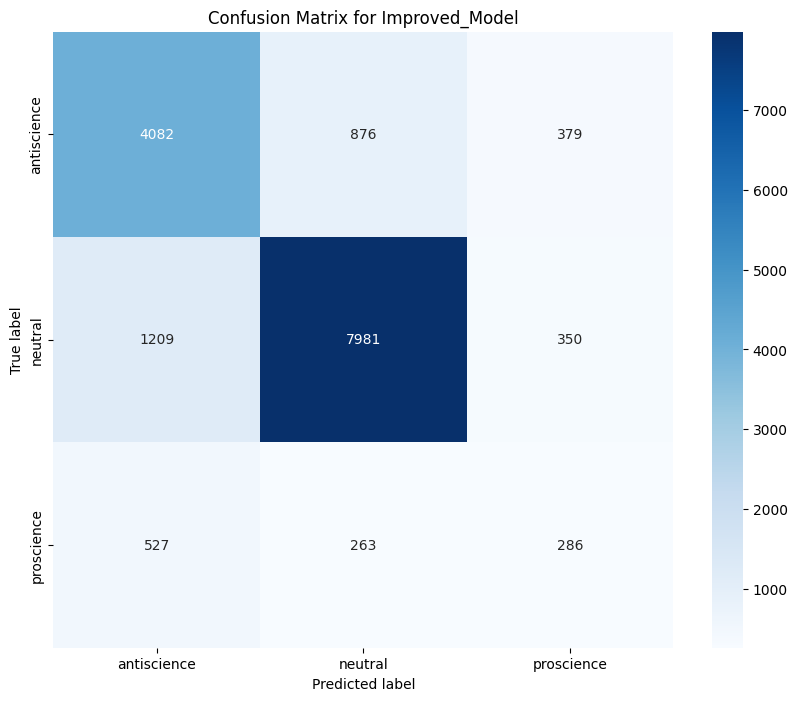

              precision    recall  f1-score   support

 antiscience       0.70      0.76      0.73      5337
     neutral       0.88      0.84      0.86      9540
  proscience       0.28      0.27      0.27      1076

    accuracy                           0.77     15953
   macro avg       0.62      0.62      0.62     15953
weighted avg       0.78      0.77      0.77     15953



In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from modAL.models import ActiveLearner, Committee
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from scipy.stats import entropy
import logging
import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class ImprovedActiveLearningPipeline:
    def __init__(self, data_file: str, embedding_column: str, label_column: str, 
                 distance_columns: list, test_size: float = 0.2, initial_labeled_ratio: float = 0.3, 
                 random_state: int = 42, n_bins: int = 10, temperature: float = 1.0):
        self.data_file = data_file
        self.embedding_column = embedding_column
        self.label_column = label_column
        self.distance_columns = distance_columns
        self.test_size = test_size
        self.initial_labeled_ratio = initial_labeled_ratio
        self.random_state = random_state
        self.n_bins = n_bins
        self.temperature = temperature  # Temperature scaling for entropy
        
        self.le = LabelEncoder()
        self.scaler = StandardScaler()
        self._log_init_info()
        
    def _log_init_info(self) -> None:
        logger.info("Initializing ImprovedActiveLearningPipeline")
        
    def parse_embedding(self, embedding_string):
        return np.fromstring(embedding_string.strip('[]'), sep=' ')

    def load_and_preprocess_data(self):
        logger.info("Loading and preprocessing data")
        data = pd.read_csv(self.data_file)
        data[self.embedding_column] = data[self.embedding_column].apply(self.parse_embedding)
        
        self.le.fit(data[self.label_column])
        data['encoded_label'] = self.le.transform(data[self.label_column])
        
        X_embeddings = np.stack(data[self.embedding_column].values)
        X_distances = data[self.distance_columns].values
        X = np.hstack((X_embeddings, X_distances))
        
        y = data['encoded_label'].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state, stratify=y)
        
        self.scaler.fit(X_train[:, -len(self.distance_columns):])
        X_train[:, -len(self.distance_columns):] = self.scaler.transform(X_train[:, -len(self.distance_columns):])
        X_test[:, -len(self.distance_columns):] = self.scaler.transform(X_test[:, -len(self.distance_columns):])
        
        logger.info(f"Data shape: {X.shape}")
        logger.info(f"Class distribution: {np.bincount(y)}")
        
        return X_train, y_train, X_test, y_test

    def temperature_scaled_entropy(self, probs):
        """Calculate entropy with temperature scaling for better uncertainty estimates."""
        scaled_probs = np.exp(np.log(probs + 1e-10) / self.temperature)
        scaled_probs /= scaled_probs.sum(axis=1, keepdims=True)
        return entropy(scaled_probs, axis=1)
    
    def hybrid_query_strategy(self, committee, X_pool, n_instances=1, n_clusters=10, query_kwargs=None):
        """Combines entropy sampling and inverse propensity sampling with diversity."""
        
        y_pool = query_kwargs.get('y_pool')  # Extract y_pool from query_kwargs

        # Step 1: Apply clustering to ensure diversity
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state)
        cluster_labels = kmeans.fit_predict(X_pool)

        # Step 2: Get mean probabilities (for inverse propensity sampling)
        votes = committee.vote(X_pool)

        # Check the shape of votes and handle accordingly
        if votes.ndim == 3:
            mean_probs = np.mean(votes, axis=0)  # Now mean_probs is (n_samples, n_classes)
        elif votes.ndim == 2:
            mean_probs = votes
        else:
            raise ValueError(f"Unexpected shape for votes: {votes.shape}")

        # Step 3: Calculate maximum probabilities across classes for each sample
        max_probs = np.max(mean_probs, axis=1)

        # Step 4: Bin the maximum probabilities and calculate inverse propensity weights
        bins = np.linspace(0, 1, self.n_bins + 1)
        digitized = np.digitize(max_probs, bins) - 1
        bin_counts = np.bincount(digitized, minlength=self.n_bins)
        inv_prop_weights = 1 / (bin_counts[digitized] + 1e-10)
        
        # Step 5: Class weights based on pool distribution
        class_counts = np.bincount(y_pool)
        class_weights = 1 / (class_counts + 1e-10)
        sample_weights = class_weights[y_pool]

        # Step 6: Entropy calculation with temperature scaling
        entropy_scores = self.temperature_scaled_entropy(mean_probs)

        # Step 7: Combine weights and entropy
        combined_weights = inv_prop_weights * sample_weights

        # Step 8: Query based on combined weights, ensuring diversity by querying from each cluster
        query_idx = []
        for cluster in np.unique(cluster_labels):
            cluster_indices = np.where(cluster_labels == cluster)[0]
            
            # Normalize weights for the current cluster
            cluster_weights = combined_weights[cluster_indices]
            cluster_weights /= cluster_weights.sum()  # Normalize to sum to 1
            
            sub_query_idx = np.random.choice(cluster_indices, size=1, replace=False, p=cluster_weights)
            query_idx.append(sub_query_idx[0])

        return np.array(query_idx), mean_probs[query_idx]


    def train_with_improvements(self, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, 
                            n_queries: int = 50, n_instances_per_query: int = 100) -> Tuple[str, list, list, np.ndarray]:
        logger.info("Starting active learning with entropy + inverse propensity sampling")
        X_initial, X_pool, y_initial, y_pool = train_test_split(
            X_train, y_train, train_size=self.initial_labeled_ratio, 
            random_state=self.random_state, stratify=y_train
        )

        models = [
            XGBClassifier(objective='multi:softprob', num_class=len(self.le.classes_), random_state=self.random_state, n_jobs=-1),
            LogisticRegression(random_state=self.random_state, max_iter=1000, multi_class='ovr'),
            GaussianNB()
        ]

        learners = [ActiveLearner(estimator=model, X_training=X_initial, y_training=y_initial) for model in models]
        committee = Committee(learner_list=learners, query_strategy=self.hybrid_query_strategy)

        accuracy_history = []
        auc_roc_history = []
        best_performance = 0
        iterations_without_improvement = 0
        max_iterations_without_improvement = 10

        for iteration in tqdm(range(n_queries), desc="Active Learning Progress"):
            # Pass y_pool explicitly through the query_kwargs parameter
            query_idx, _ = committee.query(X_pool, n_instances=n_instances_per_query, query_kwargs={'y_pool': y_pool})
            
            # Teach each learner in the committee with the queried samples
            X_teach, y_teach = X_pool[query_idx], y_pool[query_idx]
            for learner in committee:
                learner.teach(X_teach, y_teach)
            
            # Remove the queried samples from the pool
            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
            
            # Evaluate the performance after each iteration
            y_pred = committee.predict(X_test)
            y_pred_proba = committee.predict_proba(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
            
            accuracy_history.append(accuracy)
            auc_roc_history.append(auc_roc)
            
            current_performance = (accuracy + auc_roc) / 2  # Average of accuracy and AUC-ROC
            
            if current_performance > best_performance:
                best_performance = current_performance
                iterations_without_improvement = 0
                self.best_committee = committee
            else:
                iterations_without_improvement += 1

            if (iteration + 1) % 5 == 0:
                logger.info(f"Iteration {iteration + 1}/{n_queries}: Accuracy = {accuracy:.4f}, AUC-ROC = {auc_roc:.4f}")

            if iterations_without_improvement >= max_iterations_without_improvement:
                logger.info(f"Early stopping at iteration {iteration + 1} due to no improvement")
                break

        y_pred_final = committee.predict(X_test)
        cm = confusion_matrix(y_test, y_pred_final)
        
        logger.info(f"Final Accuracy: {accuracy_history[-1]:.4f}")
        logger.info(f"Final AUC-ROC: {auc_roc_history[-1]:.4f}")
        
        return accuracy_history, auc_roc_history, cm


    def run_pipeline(self) -> Tuple[dict, dict, dict, str]:
        logger.info("Running Improved Active Learning Pipeline")
        
        X_train, y_train, X_test, y_test = self.load_and_preprocess_data()
        accuracy_history, auc_roc_history, cm = self.train_with_improvements(X_train, y_train, X_test, y_test)
        
        self.model_performance = {"Improved_Model": accuracy_history}
        self.model_auc_roc = {"Improved_Model": auc_roc_history}
        self.confusion_matrices = {"Improved_Model": cm}
        
        y_pred = self.best_committee.predict(X_test)
        class_report = classification_report(y_test, y_pred, target_names=self.le.classes_)
        logger.info("Classification Report:\n" + class_report)
        
        return self.model_performance, self.model_auc_roc, self.confusion_matrices, class_report

    def plot_results(self) -> None:
        plt.figure(figsize=(12, 8))
        for model_name, accuracies in self.model_performance.items():
            plt.plot(accuracies, label=f'{model_name} - Accuracy')
        for model_name, auc_rocs in self.model_auc_roc.items():
            plt.plot(auc_rocs, label=f'{model_name} - AUC-ROC')
        plt.title('Model Performance Over Active Learning Iterations')
        plt.xlabel('Iteration Number')
        plt.ylabel('Performance')
        plt.legend()
        plt.show()

    def plot_confusion_matrices(self) -> None:
        for model_name, cm in self.confusion_matrices.items():
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.le.classes_, yticklabels=self.le.classes_)
            plt.title(f'Confusion Matrix for {model_name}')
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

# Usage Example
pipeline = ImprovedActiveLearningPipeline(
    data_file="sbert_data_with_distance_features.csv",
    embedding_column="dense_embedding",
    label_column="cleaned_classification",
    distance_columns=["distance_to_antiscience", "distance_to_neutral", "distance_to_proscience"],
    n_bins=10,  # Number of bins for Inverse Propensity
    temperature=1.5  # Temperature scaling for entropy
)

results, auc_roc_results, confusion_matrices, class_report = pipeline.run_pipeline()
pipeline.plot_results()
pipeline.plot_confusion_matrices()
print(class_report)